# Update Path and env variables

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.use_jedi = False
import os
ROOT_DIR = os.path.abspath('') # For colab and ipynb
DATA_PATH = os.path.join(ROOT_DIR, 'data')
DATA_FILE_PATH = os.path.join(DATA_PATH, 'google-search-trends.csv')

#COLAB
import sys
sys.path.insert(0, ROOT_DIR)
# sys.path.insert(0, "/home/yaatehr/miniconda3/envs/idldp/lib/python3.8/site-packages/matlab")
# sys.path.insert(0, "/home/yaatehr/miniconda3/condabin")
# sys.path.insert(0, "/home/yaatehr/miniconda3/bin")
# %env PYTHONPATH={GITHUB_PATH}
get_absolute_path = lambda x: os.path.join(ROOT_DIR,x)

VERSION_NUM="4.2"


#for LOCAL Runtimes paste the following into your terminal. make sure to update the path...
# export PYTHONPATH=$PYTHONPATH:~/programs/xprize2/covid-xprize/

# Uncomment to use the example predictor
# ! cd /content/covid-xprize/covid_xprize/examples/predictors/lstm/
# ! mkdir models
# ! cp /tests/fixtures/trained_model_weights_for_tests.h5 models/trained_model_weights.h5


# Relaxation eval

## Utils

In [2]:

import numpy as np
import math
from collections import defaultdict
import functools
import operator
import collections

# my_dict = [{'a':0, 'b':1, 'c':5}, {'b':3, 'c':2}, {'b':1, 'c':1}]
# sum_key_value = dict(functools.reduce(lambda a, b: a.update(b) or a, my_dict, collections.Counter()))
# print(my_dict)
# print(sum_key_value)

def get_top_percentile(distribution, percentile=.5):
  index_list = []
  i = 0
  current_percentile = 0
  # assert probability_normalize(distribution) == distribution,"testing the probability norm"
  args = np.argsort(distribution)[::-1]
  while current_percentile < percentile:
    current_percentile += distribution[args[i]]
    index_list.append(args[i])
    i+= 1
  return index_list

def get_percentile_indices(distribution, percentiles):
  """
  note percentiles are actually quantiles (0,1)
  """
  percentiles = copy.copy(percentiles)
  if not len(percentiles):
    assert False

  args = np.argsort(distribution)[::-1] #indices in ascending order
  sorted_dist = np.sort(distribution)[::-1]
  sorted_dist = np.cumsum(sorted_dist)
  unique_split_points = np.unique(sorted_dist)
  min_split, max_split = unique_split_points[0], unique_split_points[-1]
  if percentiles[0] < min_split: # note this only fixes edge cases, cases in teh middle will still fail if some buckets have no elements.
    print(f"updating the min split from {percentiles[0]} to {min_split}")
    percentiles[0] = min_split
  if percentiles[-1] > max_split:
    print(f"updating the max split from {percentiles[-1]} to {max_split}")
    percentiles[-1] = max_split
  # def get_next_ind(percentile, sorted_dist):
  #   try:
  #     return next(x for x, val in enumerate(sorted_dist) if val > percentile)
  #   except StopIteration e:
  #     print(
  #     return None
  try:
    split_indices = [ next(x for x, val in enumerate(sorted_dist) if val > percentile) for percentile in percentiles]
  except:
    # We assume we hit a 1 split point
    try:
      valid_dist = sorted_dist < 1
      v = np.split(sorted_dist, np.sum(valid_dist) or 1 )
      valid_dist, degenerate_dist = v[0], v[1]
      split_indices = [next(x for x, val in enumerate(valid_dist) if val > percentile) for percentile in percentiles[:-1]]
      split_indices.append(len(valid_dist))
    except:
      print("GET PERCENTILE INDICES THROWING, ")
      print("percentiles stats")
      print(distribution)
      print(sorted_dist)
      print(percentiles)
      valid_dist = sorted_dist < 1
      print("splitting at: ", np.sum(valid_dist) or 1 )
      v = np.split(sorted_dist, np.sum(valid_dist) or 1 )
      valid_dist, degenerate_dist = v[0], v[1]
      split_indices = [next(x for x, val in enumerate(valid_dist) if val > percentile) for percentile in percentiles[:-1]]
      split_indices.append(len(valid_dist))
      print(split_indices)
  return np.split(args, split_indices), np.arange(len(distribution))[args]

def get_random_element_split(distribution, num_splits, seed=0):
  if seed:
    np.random.seed(seed)
  args = np.arange(len(distribution))
  np.random.shuffle(args)
  # print(args)
  # print(num_splits)
  return np.split(args, num_splits)

def get_rank_order_splits(distribution, percentiles, scores):
  _, current_score = get_percentile_indices(distribution, percentiles)
  scores += current_score
  args = np.argsort(scores)[::-1]
  sorted_scores_dist = probability_normalize(np.sort(scores)[::-1])
  sorted_scores_dist = np.cumsum(sorted_scores_dist)
  split_indices = [next(x for x, val in enumerate(sorted_scores_dist) if val > percentile) for percentile in percentiles]
  return np.split(args, split_indices), scores


#fast Hadamard Transform
def FWHT_A(k, dist):
    if k == 1:
        return dist
    dist1 = dist[0 : k//2]
    dist2 = dist[k//2 : k]
    trans1 = FWHT_A(k//2, dist1)
    trans2 = FWHT_A(k//2, dist2)
    trans = np.concatenate((trans1+ trans2, trans1 - trans2))
    return trans

#simplex projection
def project_probability_simplex(p_estimate):
    
    k = len(p_estimate)  # Infer the size of the alphabet.
    p_estimate_sorted = np.sort(p_estimate)
    p_estimate_sorted[:] = p_estimate_sorted[::-1]
    p_sorted_cumsum = np.cumsum(p_estimate_sorted)
    i = 1
    while i < k:
        if p_estimate_sorted[i] + (1.0 / (i + 1)) * (1 - p_sorted_cumsum[i]) < 0:
            break
        i += 1
    lmd = (1.0 / i) * (1 - p_sorted_cumsum[i - 1])
    return np.maximum(p_estimate + lmd, 0)

#clip and normalize
def probability_normalize(dist):
    dist = np.maximum(dist,0) #map it to be positive
    norm = np.sum(dist)
    dist = np.true_divide(dist,norm) #ensure the l_1 norm is one
    return dist

#generate a random permutation matrix
def Random_Permutation(k):
    permute = np.random.permutation(k)
    reverse = np.zeros(k)
    for i in range(k):
        reverse[int(permute[i])] = i
    return permute,reverse

#pre-calculate Hadamard Matrix
def Hadarmard_init(k):
    H = [None] * k
    for row in range(k):
        H[row] = [True] * k
        
# Initialize Hadamard matrix of order n.
    i1 = 1
    while i1 < k:
        for i2 in range(i1):
            for i3 in range(i1):
                H[i2+i1][i3]    = H[i2][i3]
                H[i2][i3+i1]    = H[i2][i3]
                H[i2+i1][i3+i1] = not H[i2][i3]
        i1 += i1
    return H


# In[ ]:


#functions to generate distributions
def generate_geometric_distribution(k,lbd):
    elements = range(0,k)
    prob = [(1-lbd)*math.pow(lbd,x)/(1-math.pow(lbd,k)) for x in elements] # geometric dist
    return prob

def generate_uniform_distribution(k):
    raw_distribution = [1] * k
    sum_raw = sum(raw_distribution)
    prob = [float(y)/float(sum_raw) for y in raw_distribution]
    return prob

def generate_two_steps_distribution(k):
    raw_distribution = [1] * int(k/2) + [3] * int(k/2)
    sum_raw = sum(raw_distribution)
    prob = [float(y)/float(sum_raw) for y in raw_distribution]
    return prob

def generate_Zipf_distribution(k,lbd):
    raw_distribution = [1/(float(i)**(lbd)) for i in range(1,k+1)]
    sum_raw = sum(raw_distribution)
    prob = [float(y)/float(sum_raw) for y in raw_distribution]
    return prob

def generate_Dirichlet_distribution(k,lbd):  
    raw_distribution = [0] * k
    for i in range(0,k):
        raw_distribution[i] = np.random.gamma(1,1)
    sum_raw = sum(raw_distribution)
    prob = [float(y)/float(sum_raw) for y in raw_distribution]
    return prob

def kwarg_dummy(k, eps, rep, epochs, step_sz, init, dist, encode_acc = 1, encode_mode = 0, topk=.1, point_growth_rate=1, relaxation_mode=0, basegroup_size=-1, eps_relaxation=1, epoch_subdivisions=None):
  return locals()

def kwarg_dummy2(k=None, eps=None, epochs=None,  init=None, encode_acc = 1, encode_mode = 0,\
                          tiers=2, relaxation_mode=0, growth_mode=0, score_mode=0,\
                          eps_relaxation=1, epoch_subdivisions=None, split_percentiles=None, baseline_arg_map=None):
  return locals()

def get_max_min(df, col):
  return df[col].max(), df[col].min()

def counter_to_dist(count_table):
  norm = sum(count_table.values())
  dist = np.array(list(count_table.values()))/norm
  # print(f"verifying counts: counter: {count_table} \n norm: {norm}\n dist: {dist}")
  return dist




def plot_distributions():
  fig, ax = plt.subplots(nrows=1, ncols=4)
  prob_list = {
      # 'Uniform' : prob1,
      'Two_steps' : prob2,
      'Zipf' : prob3,
      'Dirchlet' : prob4,
      'Geometric' : prob5, 
  }
  i = 0
  for indices, ax in np.ndenumerate(ax):
    prob = list(prob_list.values())[i]
    prob_dist_name = list(prob_list.keys())[i]
    print(ax)
    ax.plot(prob)
    ax.set_title(prob_dist_name,  fontdict={'fontsize': 18, 'fontweight': 'medium'})
    if i == 1 or i == 3:
      ax.set_yscale("log")
    i+= 1
  fig.set_size_inches(16.5, 2)

  fig.savefig("true_distributions_k_1000.png")


## Hadamard Responses

In [3]:
# Copyright 2017 Department of Electrical and Computer Engineering, Cornell University. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# This is a package for locally private data transmission. 


#%matplotlib inline
import math
import numpy as np
import random
import matplotlib.pyplot as plt
# from functions import *


#the Hadamard randamized responce when \epsilon < 1
class Hadamard_Rand_high_priv:
    def __init__(self, absz, pri_para, encode_acc = 0): # absz: alphabet size, pri_para: privacy parameter
        #set encode_acc = 1 to enable fast encoding by intializing hadamard matrix
        self.insz = absz #input alphabet size k
        self.outsz = int(math.pow(2,math.ceil(math.log(absz+1,2)))) #output alphabet size: smallest exponent of 2 which is bigger than k
        self.outbit = int(math.ceil(math.log(absz+1,2))) #output bit length
        self.exp = math.exp(pri_para) #privacy parameter
        self.pri_para = 1/(1+math.exp(pri_para)) #flipping probability to maintain local privacy
        #self.permute, self.reverse = Random_Permutation(absz) #Initialize random permutation
        
        self.ifencode_acc = encode_acc #whether to accelerate encoding process
        if encode_acc == 1:
            self.H = Hadarmard_init(self.outsz) # initialize Hadarmard matrix
            
    def parity_check(self,x,y): #check if the hadamard entry is one (return 0 for if the entry is 1)
        z = x&y #bit and
        z_bit = bin(z)[2:].zfill(self.outbit)
        check = 0
        for i in range(0,self.outbit): #check = \sum_i (x_i y_i) （mod 2）
            check = check^int(z_bit[i]) 
        return check
                                  
    def encode_symbol(self,in_symbol):  # encode a single symbol into a privatized version
        bitin = bin(int(in_symbol)+1)[2:].zfill(self.outbit) #map the input symbol 
        # x to x+1 since we are not using the first column of the matrix
        out1 = random.randint(0,math.pow(2,self.outbit)-1) #get a random number in
        # the output alphabet as one potential output
        bitout1 = bin(out1)[2:].zfill(self.outbit)
        for i in range(0,self.outbit): #flip the bit of out1 corresponding to the left
            #  most bit in (in_symbol+1) which is one to get the other potential output
            if int(bitin[i]) == 1:
                out2 = out1 ^ (pow(2,self.outbit - i -1))
                break   
        #bitout2 = bin(out2)[2:].zfill(self.outbit)
        
        if self.ifencode_acc == 1:
            check = 1 - self.H[int(in_symbol)+1][out1]
        else:
            check = 0
            for i in range(0,self.outbit): # check if the Hadamard entry at position 
                # (in_symbol+1, out1) is one or not
                check = check^(int(bitout1[i])&int(bitin[i]))

        ra = random.random()
        if check == 0: # if it is one output out1 with prob (1-pri_para)
            if ra > self.pri_para:
                return out1
            else:
                return out2
        else: # else output out2 with prob (1-pri_para)
            if ra > self.pri_para:
                return out2
            else:
                return out1       
     
    def encode_string(self,in_list):  # encode string into a privatized string
        out_list = [self.encode_symbol(x) for x in in_list] # encode each symbol in the string
        return out_list
    
    def decode_string(self, out_list, iffast = 1, normalization = 0, verbose=False): # get the... 
        # privatized string and learn the original distribution
        #normalization options: 0: clip and normalize(default)
        #                       1: simplex projection
        #                       else: no nomalization
        
        #iffast: 0 use fast hadamard transform time O(n  + k\log k)
        #        1 no fast hadamard tansform  time O(n + k^2)
        
        l = len(out_list) 
        count,edges = np.histogram(out_list,range(self.outsz+1))
        dist = count/float(l)
        
        if iffast == 1: #if we use fast hadamard transform
            dist_mid = FWHT_A(self.outsz, dist) #do fast hadamard transform... 
            # to the frequency vector
            dist_S = (dist_mid[1:self.insz+1] + 1)/float(2) #get the frequencies of C_i
        else: #if we don't use fast hadamard transform
            num = [0]*self.insz
            for x in range(0,self.outsz):
            #print x
                for i in range(1, self.insz+1): #if output x is in C_i(locations in...
                    #  row i which is 1), add it to the count of C_i
                    if self.parity_check(i,x) == 0:
                        num[i-1] = num[i-1] + count[x]
            dist_S = np.array([float(x)/float(l) for x in num]) #get the frequencies of C_i
        if verbose: 
            print("decoded frequency of C_i before normalizations: ", dist_S)    
        
        dist = (2*dist_S*(1+self.exp)-(1+self.exp))/float(self.exp-1) #calculate the...
        # corresponding estimate for p_i
        if verbose:
            print("decoded p_i estimate before normalizations: ", dist)    

        if normalization == 0: 
            dist = probability_normalize(dist) #clip and normalize
        if normalization == 1:
            dist = project_probability_simplex(dist) #simplex projection
        
        return dist


#The Hadamard randomized response for all regimes (Modified Version)

class Hadamard_Rand_general:
    def __init__(self, absz, pri_para, encode_acc = 0): # absz: alphabet size, pri_para: privacy parameter
        self.insz = absz #input alphabet size k
        #self.outsz = int(math.pow(2,math.ceil(math.log(absz+1,2)))) #output alphabet size: smallest exponent of 2 which is bigger than k
        #self.outbit = int(math.ceil(math.log(absz+1,2))) #output bit length
        self.pri_para = 1/(1+math.exp(pri_para)) #flipping probability to maintain local privacy
        self.exp = math.exp(pri_para) #privacy parameter
        #self.initbit = int(math.floor(math.log(self.exp,2))) # number of bits indicating the block number 
        self.initbit = int(math.floor(math.log(min(2*absz,self.exp),2))) # number of bits indicating the block number
        self.part = int(math.pow(2,self.initbit)) #total number of blocks B
        self.tailbit = int(math.ceil(math.log(float(self.insz)/float(self.part)+1,2))) #number of bits indicating the location within a block
        self.partsz = int(math.pow(2,self.tailbit)) # size of each block b
        self.num_one = int(self.partsz/float(2))
        self.outbit = self.tailbit + self.initbit #total number of output bits
        self.partnum = int(math.ceil(float(self.insz)/float(self.partsz - 1)))
        self.outsz = int(self.partsz*self.partnum) # output alphabet size K
        self.permute, self.reverse = Random_Permutation(absz) #Initialize random permutation
        
        self.ifencode_acc = encode_acc #whether to accelerate encoding process
        if encode_acc == 1:
            self.H = Hadarmard_init(self.partsz) # initialize Hadarmard matrix
        
    def entry_check(self,x,y): #check if the reduced hadamard entry is one (return 0 for 1)
        x_bit = bin(x)[2:].zfill(self.outbit)
        y_bit = bin(y)[2:].zfill(self.outbit)
        for i in range(0,self.initbit): # check if they are in the same block, if not, return -1
            if x_bit[i] != y_bit[i]:
                return True
        check = False
        for i in range(self.initbit, self.outbit): #check whether the entry is one within the block
            check = check^(int(x_bit[i]) & int(y_bit[i]))
        return check
                                  
            
    def encode_symbol_rough(self,in_symbol):  # encode a single symbol into a privatized version 
        # we use coupling argument to do this
        part_index = int(in_symbol)//(self.partsz-1)
        part_pos = int(in_symbol)%(self.partsz-1)+1
        in_column = (part_index << self.tailbit) + part_pos #map the input x to the xth column with weight b/2
        #in_column = part_index * self.partsz + part_pos
        out1 = np.random.randint(0,self.outsz) #get a random number out1 in the output alphabet as a potential output
        ra = random.random()
        if ra < (2*self.part)/(2*self.part-1+self.exp): #with certain prob, output the same symbol as from uniform distribution
            return out1
        else:
            out_pos = out1 & (self.partsz - 1)
            #out_pos = out1 % self.partsz
            out1 =  out_pos + (part_index << self.tailbit) # map out1 to the same block as in_column while maintain the location within the block
            #out1 = out_pos + part_index*self.partsz
            if self.ifencode_acc == 1:
                check = self.H[part_pos][out_pos]
            else:
                check = 1 - self.entry_check(in_column,out1)

            if check == 0: #if location (in_column, out1) is one, output out1
                return out1
            else: #else flip bit at the left most location where bit representation of in_column is one 
                #bitin = bin(int(in_column))[2:].zfill(self.outbit)
                check = 1
                for i in range(self.outbit - self.initbit): 
                    if in_column%2 == 1:
                        #out1 = out1 ^ (pow(2,self.outbit - i -1))
                        out1 = out1 ^ check
                        break
                    in_column = in_column >> 1
                    check = check << 1
                return out1
            
    #delete the first row of each block
    def encode_symbol(self, in_symbol):
        while(1):
            out = self.encode_symbol_rough(in_symbol)
            if out%self.partsz != 0:
                return out
    
    def encode_string(self,in_list):  # encode string into a privatized string
        out_list = [self.encode_symbol(self.permute[x]) for x in in_list]
        return out_list
    
    
    def decode_string(self, out_list, iffast = 1, normalization = 0): # get the privatized string and learn the original distribution
        #normalization options: 0: clip and normalize(default)
        #                       1: simplex projection
        #                       else: no nomalization
        
        #iffast: 0 use fast hadamard transform time O(n  + k\log k)
        #        1 no fast hadamard tansform  time O(n + k^2)
        
        l = len(out_list)
        count,edges = np.histogram(out_list,range(self.outsz+1))
        freq = count/float(l)
        
        
        if iffast == 1:
            #parts = self.insz//(self.partsz-1) 
            freq_S = np.zeros(self.outsz)
            freq_block = np.zeros(self.partnum)
            for i in range(0, self.partnum):
                Trans = FWHT_A(self.partsz, freq[i*self.partsz: (i+1)*self.partsz])
                freq_block[i] = Trans[0]
                freq_S[i*(self.partsz-1): (i+1)*(self.partsz-1)] = ( - Trans[1:self.partsz] + Trans[0])/float(2)         
            dist_S = freq_S[0:self.insz]
            
        else:
            freq_block = np.zeros(self.part) # count the number of appearances of each block
            for i in range(0,self.part): 
                #count_block[i] = np.sum(count[i*self.partsz : (i+1)*self.partsz - 1])
                for j in range(0,self.partsz):
                    freq_block[i] = freq_block[i] + freq[i*self.partsz+j]
            #freq_block = np.true_divide(count_block,l) # calculate the frequency of each block
            #dist_block = np.true_divide((2*self.part-1+self.exp)*(freq_block)-2,self.exp-1) # calculate the estimated original prob of each block                    
            for i in range(0, self.insz): 
                pi = int(i)//(self.partsz-1)
                ti = pi*self.partsz + int(i)%(self.partsz-1)+1
                for x in range(pi*self.partsz, (pi+1)*self.partsz): # count the number of appearances of each C_i
                    if self.entry_check(ti,x) == 0:
                        dist_S[i] = dist_S[i] + freq[x]
                        
        lbd = float(self.outsz - self.partnum)/float(self.num_one)
        c1 = lbd-1+self.exp
        
        dist_block = np.true_divide(c1*(freq_block)- 2 + 1/float(self.num_one),self.exp-1) # calculate the estimated original prob of each block
        
        c2 = self.exp - 1
        #dist = [float(2*c1*dist_S[i] - c2*dist_block[i//(self.partsz-1)] - 2)/float(c3) for i in range(0,self.insz) ]
        dist = [float(2*c1*dist_S[i] - c2*dist_block[i//(self.partsz-1)] - 2)/float(c2) for i in range(0,self.insz) ]
        
        if normalization == 0: 
            dist = probability_normalize(dist) #clip and normalize
        if normalization == 1:
            dist = project_probability_simplex(dist) #simplex projection
        
        #reverse the permuation
        dist1 = np.zeros(self.insz)
        for i in range(self.insz):
            dist1[int(self.reverse[i])] = dist[i]
        return dist1
    
    
    def decode_string_old(self, out_list): # get the privatized string and learn the original distribution
        
        l = len(out_list)
        dist_S = np.zeros(self.insz)
        count,edges = np.histogram(out_list,range(self.outsz+1))
        freq = count/float(l)
        
        freq_block = np.zeros(self.part) # count the number of appearances of each block
        for i in range(0,self.part): 
            #count_block[i] = np.sum(count[i*self.partsz : (i+1)*self.partsz - 1])
            for j in range(0,self.partsz):
                freq_block[i] = freq_block[i] + freq[i*self.partsz+j]
        
        
        #freq_block = np.true_divide(count_block,l) # calculate the frequency of each block
        dist_block = np.true_divide((2*self.part-1+self.exp)*(freq_block)-2,self.exp-1) # calculate the estimated original prob of each block
                    
        for i in range(0, self.insz): 
            pi = int(i)//(self.partsz-1)
            ti = pi*self.partsz + int(i)%(self.partsz-1)+1
            for x in range(pi*self.partsz, (pi+1)*self.partsz): # count the number of appearances of each C_i
                if self.entry_check(ti,x) == 0:
                    dist_S[i] = dist_S[i] + freq[x]

        #dist_S = np.zeros(self.insz)
        #dist_S = np.true_divide(num,l) #calculate the frequency of each C_i
        dist_inter = np.true_divide(2*(dist_S*(2*self.part-1+self.exp)-1),self.exp-1) # calculate intermediate prob
        dist = [dist_inter[i] - dist_block[i//(self.partsz-1)] for i in range(0,self.insz)] # calculate the estimated prob for each symbol
        dist = np.maximum(dist,0) #map it to be positive
        norm = np.sum(dist)
        dist = np.true_divide(dist,norm) #ensure the l_1 norm is one
        return dist
    
    #def decode_string_normalize(self, out_list): #normalized outputs using clip and normalize
    #    dist = self.decode_string_permute(out_list)
    #    dist = probability_normalize(dist)
    #    return dist
    
    #def decode_string_project(self, out_list): #projected outputs
    #    dist = self.decode_string_permute(out_list)
    #    dist = project_probability_simplex(dist)
    #    return dist
    
    #def decode_string_permute(self, out_list): # get the privatized string and learn the original distribution
    #    dist1 = self.decode_string_fast(out_list)
    #    dist = np.zeros(self.insz)
    #    for i in range(self.insz):
    #        dist[int(self.reverse[i])] = dist1[i]
    #    return dist


# In[ ]:


#The Hadamard randomized response for all regimes (original version)
class Hadamard_Rand_general_original:
    def __init__(self, absz, pri_para, encode_acc = 0): # absz: alphabet size, pri_para: privacy parameter
        #set encode_acc = 1 to enable fast encoding by intializing hadamard matrix
        
        self.insz = absz #input alphabet size k
        #self.outsz = int(math.pow(2,math.ceil(math.log(absz+1,2)))) #output alphabet size: smallest exponent of 2 which is bigger than k
        #self.outbit = int(math.ceil(math.log(absz+1,2))) #output bit length
        self.pri_para = 1/(1+math.exp(pri_para)) #flipping probability to maintain local privacy
        self.exp = math.exp(pri_para) #privacy parameter
        #self.initbit = int(math.floor(math.log(self.exp,2))) # number of bits indicating the block number 
        self.initbit = int(math.floor(math.log(min(2*absz,self.exp),2))) # number of bits indicating the block number
        self.part = int(math.pow(2,self.initbit)) #number of blocks B
        self.tailbit = int(math.ceil(math.log(float(self.insz)/float(self.part)+1,2))) #number of bits indicating the location within a block
        self.partsz = int(math.pow(2,self.tailbit)) # size of each block b
        self.outbit = self.tailbit + self.initbit #total number of output bits
        self.outsz = int(math.pow(2,self.outbit)) # output alphabet size K
        self.permute, self.reverse = Random_Permutation(absz) #Initialize random permutation
        
        self.ifencode_acc = encode_acc #whether to accelerate encoding process
        if encode_acc == 1:
            self.H = Hadarmard_init(self.partsz) # initialize Hadarmard matrix
        
        
    def entry_check(self,x,y): #check if the reduced hadamard entry is one (return 0 for 1)
        x_bit = bin(x)[2:].zfill(self.outbit)
        y_bit = bin(y)[2:].zfill(self.outbit)
        for i in range(0,self.initbit): # check if they are in the same block, if not, return -1
            if x_bit[i] != y_bit[i]:
                return True
        check = False
        for i in range(self.initbit, self.outbit): #check whether the entry is one within the block
            check = check^(int(x_bit[i]) & int(y_bit[i]))
        return check
                                  
    
    def encode_symbol(self,in_symbol):  # encode a single symbol into a privatized version 
        # we use coupling argument to do this
        part_index = int(in_symbol)//(self.partsz-1)
        part_pos = int(in_symbol)%(self.partsz-1)+1
        in_column = (part_index << self.tailbit) + part_pos #map the input x to the xth column with weight b/2
        #in_column = part_index * self.partsz + part_pos
        out1 = np.random.randint(0,self.outsz) #get a random number out1 in the output alphabet as a potential output
        ra = random.random()
        if ra < (2*self.part)/(2*self.part-1+self.exp): #with certain prob, output the same symbol as from uniform distribution
            return out1
        else:
            out_pos = out1 & (self.partsz - 1)
            #out_pos = out1 % self.partsz
            out1 =  out_pos + (part_index << self.tailbit) # map out1 to the same block as in_column while maintain the location within the block
            #out1 = out_pos + part_index*self.partsz
            if self.ifencode_acc == 1:
                check = 1 - self.H[part_pos][out_pos]
            else:
                check = self.entry_check(in_column,out1)

            if check == 0: #if location (in_column, out1) is one, output out1
                return out1
            else: #else flip bit at the left most location where bit representation of in_column is one 
                #bitin = bin(int(in_column))[2:].zfill(self.outbit)
                check = 1
                for i in range(self.outbit - self.initbit): 
                    if in_column%2 == 1:
                        #out1 = out1 ^ (pow(2,self.outbit - i -1))
                        out1 = out1 ^ check
                        break
                    in_column = in_column >> 1
                    check = check << 1
                return out1
    
    def encode_string(self,in_list): #permute before encoding
        out_list = [self.encode_symbol(self.permute[x]) for x in in_list]
        return out_list        
    
    
    def decode_string(self, out_list,iffast = 1, normalization = 0): # get the privatized string and learn the original distribution
        #normalization options: 0: clip and normalize(default)
        #                       1: simplex projection
        #                       else: no nomalization
        
        #iffast: 0 use fast hadamard transform time O(n  + k\log k)
        #        1 no fast hadamard tansform  time O(n + kB), B is the block size
        
        l = len(out_list)
        count,edges = np.histogram(out_list,range(self.outsz+1))
        freq = count/float(l)
        
        if iffast == 1:
            parts = self.insz//(self.partsz-1) 
            freq_S = np.zeros((parts+1)*self.partsz)
            freq_block = np.zeros((parts+1)*self.partsz)
        
            for i in range(0, parts+1):
                Trans = FWHT_A(self.partsz, freq[i*self.partsz: (i+1)*self.partsz])
                freq_block[i] = Trans[0]
                freq_S[i*(self.partsz-1): (i+1)*(self.partsz-1)] = (Trans[1:self.partsz] + Trans[0])/float(2) 
            dist_S = freq_S[0:self.insz]
        
            dist_block = np.true_divide((2*self.part-1+self.exp)*(freq_block)-2,self.exp-1) # calculate the estimated original prob of each block
        
        else:
            freq_block = np.zeros(self.part) # count the number of appearances of each block
            for i in range(0,self.part): 
                #count_block[i] = np.sum(count[i*self.partsz : (i+1)*self.partsz - 1])
                for j in range(0,self.partsz):
                    freq_block[i] = freq_block[i] + freq[i*self.partsz+j]     
                    
            dist_block = np.true_divide((2*self.part-1+self.exp)*(freq_block)-2,self.exp-1) # calculate the estimated original prob of each block
            for i in range(0, self.insz): 
                pi = int(i)//(self.partsz-1)
                ti = pi*self.partsz + int(i)%(self.partsz-1)+1
                for x in range(pi*self.partsz, (pi+1)*self.partsz): # count the number of appearances of each C_i
                    if self.entry_check(ti,x) == 0:
                        dist_S[i] = dist_S[i] + freq[x]
        
        dist_inter = np.true_divide(2*(dist_S*(2*self.part-1+self.exp)-1),self.exp-1) # calculate intermediate prob
        dist = [dist_inter[i] - dist_block[i//(self.partsz-1)] for i in range(0,self.insz)] # calculate the estimated prob for each symbol
        
        if normalization == 0: 
            dist = probability_normalize(dist) #clip and normalize
        if normalization == 1:
            dist = project_probability_simplex(dist) #simplex projection
        
        #reverse the permuation
        dist1 = np.zeros(self.insz)
        for i in range(self.insz):
            dist1[int(self.reverse[i])] = dist[i]
        return dist1


## Ground Truth Evaluation

### Utils

In [4]:
import pandas as pd
from collections import defaultdict
softmax = lambda x : np.exp(x)/sum(np.exp(x))

DEFAULT_EPOCH_GROWTH_RATE = 0
DEFAULT_SUBDIVISION_GROUTH_RATE=0

def ground_truth_comp(df, d2, col):
  """
  take in the decoded df, ground truth df, and target col
  return dict of key: pred - ground truth
  """
  # df = pd.DataFrame({"a": [1, 1, 3, 4], "b": [5,6,7,7]})
  # d2 = pd.DataFrame({"a": [1, 1, 3, 4, 5, 6, 3], "b": [5,6,7,7,0,0,0]})
  df_val_counts = df[col].value_counts(sort=False)
  # ground_truth_counts = ground_truth_hist[col]
  ground_truth_counts = d2[col].value_counts(sort=False)
  eval_map = defaultdict(lambda : 0, zip( df_val_counts.keys(), df_val_counts.values))
  ground_truth_val, ground_truth_key = ground_truth_counts.values, ground_truth_counts.keys()
  # print(df["a"].value_counts(sort=False).keys())
  comparison_map = defaultdict(lambda: 0, zip(ground_truth_key, ground_truth_val))
  differences = {k: (eval_map[k] or 0) - x for k, x in  comparison_map.items()}
  # print(differences)
  return differences

def get_growth_rate(df, subdivisions, mode=0):
  if mode==0: #uniform
    return  [int(len(df) * i/(subdivisions)) for i in range(1, subdivisions)]
  elif mode == 1: #logrhymic?? tf is this? sketchy exponential
    return  (len(df) *np.power(2, [ i/epoch_subdivisions + 1 for i in range(1, epoch_subdivisions)])).astype(int)
  elif mode == 2:
    return  (len(df) *np.cumsum(softmax(np.power(2, [ i for i in range(1, epoch_subdivisions)])))).astype(int)

  else:
    assert False, "growth mode not implemented"

# def get_epoch_df(df, epochs, epoch): #TODO Fix this it goes backwards and ends on full starts on full
#   return df[:int(len(df)*(epoch)/epochs)] if epoch < epochs else df
def generate_percent_err(baseline_err, input_err):
    if np.isnan(( 1 - (input_err/baseline_err[:len(input_err)])) * 100).any():
        print(f"baseline_err: {baseline_err}")
        print(f"input_err: {input_err}")
        print( ( 1 - (input_err/baseline_err[:len(input_err)])) * 100)
    return (( 1 - (input_err/baseline_err[:len(input_err)])) * 100).flatten()


def gen_side_by_side_boxplots(scatter_results, indices, scatter_titles, figure_title):
  """
  scatter_results: 
  indices: the x axis labels (number of items in the given test
  scatter_titles: raw (l1) err, raw baseline err, raw l2 err, raw l2 err (sahould we use RMSE instead ofg the 
  """
  fig, ax = plt.subplots(nrows=len(scatter_results)//2, ncols=2)
  fig.suptitle(figure_title, fontsize=16)
  fig.set_size_inches(10, 20)
  ax = np.ravel(ax, order="F")


  upper_y_limit = 0
  lower_y_limit = float("inf")
  limits  = [(lower_y_limit, upper_y_limit)]*3
  for i, data in enumerate(scatter_results):
    lower_y_limit, upper_y_limit = limits[i %3]
    # bp = ax[i].boxplot(data) 
    # print(data)
    # print(f"this is {i} for data ^")
    max_y = np.max(data)
    min_y = np.min(data)
    upper_y_limit = max_y if max_y >= upper_y_limit else upper_y_limit
    lower_y_limit = min_y if min_y <= lower_y_limit else lower_y_limit
    ax[i].boxplot(data) 
    # ax[i].set_title(scatter_titles[i]) # this many out of total number of points
    ax[i].set_xlabel("Number of Samples")
    ax[i].set_ylabel(f"Raw {scatter_titles[i]}")
    # ax[i].set_ylim((-50, 50))
    ax[i].set_xticklabels(indices)
    limits[i % 3]= (lower_y_limit, upper_y_limit)

  slack = [(upper_y_limit - lower_y_limit)*.05 for lower_y_limit, upper_y_limit in limits]
  limits = [(lower_y_limit - slack[i], upper_y_limit + slack[i]) for i, (lower_y_limit, upper_y_limit) in enumerate(limits)]

  for i, a in enumerate(ax): # set each compared axis to be the same scale
    a.set_ylim(limits[i% 3])
    a.yaxis.grid(True, which='both')

  ax = np.reshape(ax, (len(scatter_results)//2, 2))
  fig.show()
  plt.pause(0.1)


def gen_aggregate_column_boxplot(input_metrics, baseline_metric_list, indices, baseline_names, interest_cols, figure_title):
  """
  input_metrics: list of metrics of shape (n_iterations, len(indices)) that should match the order of interest cols (and be same length)
  baseline_metric_list: list of list metrics of same format as input metrics, one for each baseline
  indices: the x axis labels (number of items in the given test
  baseline_names: list of strings for baseline names
  interest_cols: list of metric type names (ie raw (l1) err, l2 err, rmse)
  figure title:  string listing experiment conditions nad params. 
  """

  colors = ['lightblue', 'lightgreen', 'tan', 'pink', 'cyan']

  r = len(input_metrics)
  n = 1 + len(baseline_metric_list)
  fig, ax = plt.subplots(nrows=r)
  fig.suptitle(figure_title, fontsize=16)
  fig.set_size_inches(10, 20)

  upper_y_limit = 0
  lower_y_limit = float("inf")
  limits  = [(lower_y_limit, upper_y_limit)]*r
  all_bps = []
  widths = 1/(n+1)
  for i, data in enumerate([input_metrics, *baseline_metric_list]):

    # print(data)
    # print(data.shape)
    # print(indices.shape)
    bps, new_lim = gen_column_boxplot(data,indices, interest_cols, ax, np.arange(len(indices)) + i/n, limits, widths, colors[i])
    all_bps.extend(bps)
    limits = new_lim

  slack = [(upper_y_limit - lower_y_limit)*.05 for lower_y_limit, upper_y_limit in limits]
  limits = [(lower_y_limit - slack[i], upper_y_limit + slack[i]) for i, (lower_y_limit, upper_y_limit) in enumerate(limits)]

  def slice_per(source, step):
      return [source[i::step] for i in range(step)]
  bp_ax_list = slice_per(all_bps, r)
  # print("LIMITS: ")
  # print(limits)
  for i, a in enumerate(ax): # set each compared axis to be the same scale
    a.set_ylim(limits[i% r])
    a.yaxis.grid(True, which='both')
    a.legend([bp["boxes"][0] for bp in bp_ax_list[i]], ["experimental"] + baseline_names, loc='upper right')
    a.set_xlabel("Number of Samples")
    a.set_ylabel(f"Raw {interest_cols[i]}")
    a.set_xticks(np.arange(len(indices)) + .3)
    a.set_xticklabels(indices)
    

  fig.show()
  plt.pause(0.1)



def gen_column_boxplot(metrics, indices, interest_cols, ax, right_shift, limits, width, color):
  """
  metrics: list of metrics of shape (n_iterations, len(indices)) that should match the order of interest cols (and be same length)
  indices: the x axis labels (number of items in the given test
  interest_cols: list of metric type names (ie raw (l1) err, l2 err, rmse)
  ax: a list of axis to plot on 9one for each interest col
  right_shift: to prevent boxx and whiskers from overlapping.
  """

  bps = []
  new_lims = []
  for i, data in enumerate(metrics):
    # print(data.shape)
    lower_y_limit, upper_y_limit = limits[i]
    max_y = np.max(data)
    min_y = np.min(data)
    upper_y_limit = max_y if max_y >= upper_y_limit else upper_y_limit
    lower_y_limit = min_y if min_y <= lower_y_limit else lower_y_limit
    new_lims.append((lower_y_limit, upper_y_limit))

    bp = ax[i].boxplot(data, positions = right_shift, notch=True, patch_artist=True, 
                  boxprops=dict(
                      color=color,
                      facecolor=color
                  ),
                  widths = width
                  )
    bps.append(bp)
    medians = np.median(data, axis=0)
    ax[i].plot(right_shift, medians, color=color)


  return bps, new_lims





def generate_plot_for_metrics(inputs, baselines, indices, plot_labels, figure_title="temp plot", filename="tempplt.png", save_images=True, output_counts=False, fig=None, ax=None):

    if fig == None:
      fig, ax = plt.subplots(nrows=len(inputs), ncols=1) 
    
    fig.set_size_inches(8.5, 10)
    fig.suptitle(figure_title, fontsize=16)
    for i, metric in enumerate(inputs):
        baseline_metric = baselines[i]
        percent_errors = generate_percent_err(baseline_metric, metric)
        
        print("v"*50)
        print(percent_errors)
        # print(step_sz)
        widths = np.insert(indices[:-1],0,0)
        widths = indices - widths
        print(indices)
        try:
          indices = indices.to_list()
        except:
          pass
        print(len(indices))
        print(len(percent_errors))
        print("^"*30)
        barlist = ax[i].bar(indices, percent_errors, width=widths*0.75) # this many out of total number of points
        for j, percent in enumerate(percent_errors):
          if percent < 0:
            barlist[j].set_color('r')
          else:
            barlist[j].set_color('g')
        ax[i].set_title(plot_labels[i]) # this many out of total number of points
        ax[i].set_xlabel("Number of Samples")
        ax[i].set_ylabel("Avg Percent Improvement (0 is baseline perf)")
        ax[i].set_ylim((-50, 50))
        ax[i].set_xticks(indices)
        rects = ax[i].patches
        print(metric - baseline_metric)
        bar_labels = [f"{float(i):.1f}" for i in (abs(metric - baseline_metric).flatten() if output_counts else percent_errors)]
        for rect, label in zip(rects, bar_labels):
            height = rect.get_height()
            x_value = rect.get_x() + rect.get_width() / 2

            # Number of points between bar and label. Change to your liking.
            space = 5
            # Vertical alignment for positive values
            va = 'bottom'

            # If value of bar is negative: Place label below bar
            if height < 0:
                # Invert space to place label below
                space *= -1
                # Vertically align label at top
                va = 'top'
            ax[i].annotate(label, (x_value, height), xytext=(0, space), textcoords="offset points", ha='center', va=va)
        # ax[i].legend()
    fig.show()
    if save_images:
        plt.savefig(filename+ ".png")
    plt.pause(0.1)


def generate_plot_for_baselines(inputs, indices, plot_labels, figure_title="temp plot", filename="tempplt.png"):
    print(inputs)
    fig, ax = plt.subplots(nrows=len(inputs[0]), ncols=1) 
    fig.set_size_inches(8.5, 10)
    fig.suptitle(figure_title, fontsize=16)
    colors = ['r', 'y', 'g']
    legend = ['HR', "RSHR", "PSHR"]
    for k, metric_group in enumerate(inputs):
        # print(indices)
        # print("v"*50)
        # print(percent_errors)
        # print(step_sz)
        widths = np.insert(indices[:-1],0,0)
        widths = indices - widths
        # print(indices)
        # print(widths)
        try:
          indices = indices.to_list()
        except:
          pass
        # print(len(indices))
        # print(len(percent_errors))
        # print("^"*30)
        for i, metric in enumerate(metric_group):
          # print((indices +widths*.25*k).astype(int), metric, (widths*0.25).astype(int))
          # barlist = ax[i].bar(indices +widths*.25*k, metric.flatten(), width=widths*0.25, color=colors[k]) 
          barlist = ax[i].plot(indices, metric.flatten(), color=colors[k], label=legend[k]) 
          # for j, percent in enumerate(metric.flatten()):
          #   if percent < 0:
          #     barlist[j].set_color('r')
          #   else:
          #     barlist[j].set_color('g')
          ax[i].set_title(plot_labels[i]) # this many out of total number of points
          ax[i].set_xlabel("Number of Samples")
          ax[i].set_ylabel("Error")
          # ax[i].set_ylim((-50, 50))
          ax[i].set_xticks(indices)
          ax[i].legend()
          # rects = ax[i].patches
          # print(metric - baseline_metric)
          # bar_labels = [f"{float(i)*100:.1f}"  if len(inputs) == 2 else f"{float(i):.1f}" for i in (metric).flatten()]
          # for rect, label in zip(rects, bar_labels):
          #     height = rect.get_height()
          #     x_value = rect.get_x() + rect.get_width() / 2

          #     # Number of points between bar and label. Change to your liking.
          #     space = 5
          #     # Vertical alignment for positive values
          #     va = 'bottom'

          #     # If value of bar is negative: Place label below bar
          #     if height < 0:
          #         # Invert space to place label below
          #         space *= -1
          #         # Vertically align label at top
          #         va = 'top'
          #     ax[i].annotate(label, (x_value, height), xytext=(0, space), textcoords="offset points", ha='center', va=va)
        # ax[i].legend()
    fig.show()
    plt.savefig(filename+ ".png")
    plt.pause(0.1)

### eval

In [5]:
import timeit
import scipy.io as io
import datetime

import numpy as np
import random
import math
import matplotlib.pyplot as plt
import scipy.io as io
from typing import List, Dict, Any
from collections import Counter
from itertools import chain
from RR_RAPPOR import RAPPOR
from IDLDP.pg1 import IDLDP, LDP_MECHANISMS


# LDP_MECHANISMS = [ "hadamard", "oue_basic", "rappor_basic", "idldp_opt0", "rappor_idldp_opt1", "oue_idldp_opt_0"]

def generate_dist(output_distribution_list, in_list_sizes, element_map, alphabet_size,  verbose=True):
    merged_pred = np.zeros(alphabet_size)
    for i, output_list in enumerate(output_distribution_list):
      if verbose  :
          print(f"distribution number {i}")
          print(f"output_distributions: {output_list}")
          print(f"element_map: {element_map[str(i)]}")
          print(f"in list size: {in_list_sizes[i]}")
      merged_pred[element_map[str(i)]] += np.nan_to_num(output_list)*in_list_sizes[i]

    merged_pred = probability_normalize(merged_pred)
    return merged_pred

def evaluate_ground_truth(ground_truth_hist, df, col, alphabet_size, k=None, eps=None, \
                          epochs=None,  init=None, encode_acc = 1, encode_mode = 0,\
                          tiers=2, relaxation_mode=0, score_mode=0, growth_mode=0, \
                          privacy_budget=None, epoch_subdivisions=None, split_percentiles=None,\
                          num_repititions=10, baseline_arg_map=None, save_images=True, output_counts = True, seed=0,
                          idldp_config = None, ldp_mechanism="hadamard"):
    # fix alphabet size and privacy levl, get the error plot with respect to sample size
    function_kwargs = locals()
    k = alphabet_size
    verbose = False
    # output_counts = False # set to true for distribution over counts instead of counts
    # print(f"evaluate_ground_truth kwargs: {function_kwargs}")
    #Args:
    # k : alphabet size,  eps: privacy level, rep: repetition times to compute a point
    # epochs: number of points to compute
    
    # encode_acc : control whether to use fast encoding for hadamard responce
    #           recommended and default: 1 use fast encoding when k < 10000
    #                                    if memory use is high, disable this
    
    # mode: control encoding method for rappor and subset selection
    #       0 for standard, which is fast but memory intensive
    #       1 for light, which is relatively slow but not memory intensive
    #       2 for compress, where we compress the output of rappor and subsetselection into locations of ones.
    #       recommended and default: 0 when k <= 5000 n <= 1000000
    #                               if memory use is high, use light mode
    #       you can also create other modes by modifying the code
    # print('Alphabet size:', k)
    # print('Privacy level:', eps)
    if seed:
      np.random.seed(seed)
    baseline_flag = False
    if not epoch_subdivisions:
        epoch_subdivisions = epochs
    elif epoch_subdivisions == -1:
      epoch_subdivisions = 1
      baseline_flag = True
      if verbose:
        print("IN THE BASELINE EVALUATION\n")
    assert relaxation_mode in [0,1]," only 2 relaxation modes implemented"
    # indices = range(1, epoch_subdivisions + 1)
    indices = []


    assert ldp_mechanism in LDP_MECHANISMS, f'ldp mechanism must be one of {LDP_MECHANISMS} but got {ldp_mechanism}'
    if LDP_MECHANISMS.index(ldp_mechanism) > 0: #if we in an IDLDP config
      assert idldp_config is not None, "must have a valid idldp config"

    #TODO init the privacy budget if none?
    if privacy_budget is None:
      privacy_budget = [1] + [1.2]*(tiers-1)
    assert len(privacy_budget) == tiers, f"privacy budget len is {len(privacy_budget)} but must match tiers ({tiers})"

    tot_mae = []
    tot_counts = []
    tot_count_mae = []
    tot_mse = []
    tot_count_mse = []
    tot_count_rmse = []
    tot_time = []

    epoch_growth_rate = get_growth_rate(df, epochs, mode=DEFAULT_EPOCH_GROWTH_RATE)
    # print("="*50)
    # print("EPOCH GROWTH RATE")
    # print(epoch_growth_rate)
    for epoch in range(epochs): # remember that this is for each set of final point sizes
        if verbose:
          print(f"epoch number {epoch}")
        subdiv_growth_rate = None
        epoch_df = df[:epoch_growth_rate[epoch]] if epoch < epochs - 1 else df
        indices.append(len(epoch_df))
        if epoch_subdivisions > 1:
        # epoch_df = epoch_df.reset_index()
          subdiv_growth_rate = get_growth_rate(epoch_df, epoch_subdivisions, mode=growth_mode)
          # print(f"epoch subdivision split points: {subdiv_growth_rate}")
          epoch_subdivision_dfs = np.split(epoch_df, subdiv_growth_rate)
          assert len(epoch_subdivision_dfs) == epoch_subdivisions, " should have the same numebr fo segments as subdivisions"
        elif epoch_subdivisions == 1:
          epoch_subdivision_dfs = [epoch_df]
        else:
          assert False, " epoch subdivision should be greater than 0"
        
        # TODO shuffle rows? subsection list, np.split, make that the in list....
        # print("="*50)
        # print("subdivisions")
        # print(subdiv_growth_rate if subdiv_growth_rate is not None else "all")
        # # print("="*50)
        # print(len(epoch_subdivision_dfs))

        # chunks = np.split(range(k), tiers)
        # element_map = {str(i): chunks[i] for i in range(tiers)}
        element_map = {str(i): list(range(k)) if i == 0 else [] for i in range(tiers)}

        # to store l1 errors for each method
        l1_1 = [0]*epoch_subdivisions
        l1_2 = [0]*epoch_subdivisions
        l1_3 = [0]*epoch_subdivisions
        l1_4 = [0]*epoch_subdivisions
        
        # to store l2 errors for each method
        l2_1 = [0]*epoch_subdivisions
        l2_2 = [0]*epoch_subdivisions
        l2_3 = [0]*epoch_subdivisions
        l2_4 = [0]*epoch_subdivisions
        l2_5 = [0]*epoch_subdivisions

        # to store decodign time for each method
        t1_1 = [0]*epoch_subdivisions
        t1_2 = [0]*epoch_subdivisions
        t1_3 = [0]*epoch_subdivisions
        t1_4 = [0]*epoch_subdivisions
        past_sizes = []

        for iter in range(epoch_subdivisions): # iterate with in the final point size over rthe number of points within
        # doesn't have to match the number of epochs but currently does
            if verbose:
              print(f"Computing epoch subdivision {iter}")
            in_list = epoch_subdivision_dfs[iter][col].to_numpy()
            n = len(in_list)
            past_sizes.append(n)
            split_percentile_scores = np.zeros(alphabet_size)

            if baseline_flag and tiers == 2: # bootstrap the ele tiers appropriately
              raw_counter = Counter(in_list)
              counter_with_zeros = {key: raw_counter[key] or 0 for key in element_map["0"]}
              prob_est_topk_4 = counter_to_dist(counter_with_zeros)

              if score_mode == 0:
                ranked_distribution_splits = get_random_element_split(prob_est_topk_4, [len(prob_est_topk_4)//2], seed=seed)
              elif score_mode == 1:
                ranked_distribution_splits, split_percentile_scores = get_percentile_indices(prob_est_topk_4, split_percentiles)
              else:
                assert False, "score mode not implemented for Baseline"

            # print(f"in list for iter {iter} with n {n} \n ")
            # print(past_sizes)
            # print(np.sum(past_sizes))
            # print(f"out of {len(epoch_df)}")

            #get subsectino of indices. 
            count4 = 0
            t4 = 0

            ele_domain_sizes = [len(element_map[v]) for v in element_map.keys()]
            if verbose:
              print("ele tiers ", ele_domain_sizes)
            enc = 1 if encode_acc == 1 else 0
            count_table = Counter()

            index_list = [np.concatenate([np.where(in_list == x) for x in domain_elements], axis = 1).flatten() for domain_elements in element_map.values() if len(domain_elements)]
            in_list_sizes = [len(in_list) for in_list in index_list]

            if LDP_MECHANISMS.index(ldp_mechanism) == 0:
              # non_topk_sample_ind = np.array(range(n))
              ldp_instance_list = [Hadamard_Rand_high_priv(q, eps*privacy_budget[i], enc) for i, q in enumerate(ele_domain_sizes) if q != 0]
              encoding_list = [ldp_instance_list[i].encode_string(in_list[domain_elements]) for i, domain_elements in enumerate(index_list)]
              #first generate actual subset of elements we want to split out from this sampling
            else:
              #we want to modify the ind_to_tier map based on the first round respoonse
              #for the first round response just use OUE_basic/rappor_basic? seems unfair to rappor but im sure people using rappor have areason for using it not OUE.
              #TODO
              if LDP_MECHANISMS.index(ldp_mechanism) < 3:
                ldp_instance_list = [RAPPOR(q, eps*privacy_budget[i], config=idldp_config) for i, q in enumerate(ele_domain_sizes) if q != 0]
                encoding_list = [ldp_instance_list[i].encode_string(in_list[domain_elements]) for i, domain_elements in enumerate(index_list)]
              else:
                new_ind_to_tier = {}
                for key, vals in element_map.items():
                  new_ind_to_tier.update({v: key for v in vals})

                idldp_config["ind_to_tier"] = new_ind_to_tier if iter != 0 else None
                ldp_instance_list = [RAPPOR(alphabet_size, eps, config=idldp_config)]
                encoding_list = [ldp_instance_list[0].encode_string(in_list)] #for IDLDP methods just encode the entire string

            #TODO pass all the params in and the ntest this tomorrow YAATEHR


            start_time = timeit.default_timer()
            output_distribution_list = []
            if relaxation_mode == -1 or iter == 0:
              output_distribution_list = [ldp_instance_list[i].decode_string(encoding) for i, encoding in enumerate(encoding_list)]
            elif relaxation_mode == 0:
              raw_counter = Counter(in_list[index_list[0]])
              counter_with_zeros = {key: raw_counter[key] or 0 for key in element_map["0"]}
              for i, key in enumerate(counter_with_zeros.keys()):
                  assert key == element_map["0"][i], "key and element key should match"
              prob_est_topk_4 = counter_to_dist(counter_with_zeros)
              output_distribution_list = [ldp_instance_list[i].decode_string(encoding) if i != 0 else prob_est_topk_4 for i, encoding in enumerate(encoding_list)]

            elif relaxation_mode == 1:
              output_distribution_list = [ldp_instance_list[i].decode_string(encoding) for i, encoding in enumerate(encoding_list)]
            else:
              assert False, "should have a new defined relaxation mode"

            # print(in_list_sizes)
            prob_est = generate_dist(output_distribution_list, in_list_sizes, element_map, alphabet_size, verbose=verbose)
            # print(prob_est)
            if not baseline_flag: #Compute ranked distribution splits with logic for making sure percentiles add up to 1
            #Note that whne we are in the baselines we just compute the ranks once
              if len(split_percentiles) == 1 and len(index_list) == 1:
                if verbose:
                  print("FIRST BRNACH OF PERCENTILE MDOS")
                current_split_percentiles = split_percentiles
              elif len(split_percentiles) > len(index_list) -1:
                if verbose:
                  print(len(split_percentiles), len(index_list))
                  print(in_list_sizes)
                  print(ldp_instance_list)
                sheered_percentiles = split_percentiles[len(index_list) -1:]
                slack_percentile = np.sum(sheered_percentiles) / ( len(index_list) -1 )
                print("updating slack percentile ", slack_percentile)
                assert slack_percentile > 0 and slack_percentile < 1, "slakc percentile should be a fraction"
                current_split_percentiles = split_percentiles[len(index_list)-1:] + slack_percentile
                #TODO TEST TEH DISTRIBUTION SPLITS
              elif len(split_percentiles) == len(index_list) -1: # ie bootstrap iteration
                if verbose:
                  print("LAST BRANCH OF PERCENTILE MODS")
                current_split_percentiles = split_percentiles
              else:
                assert False, "Will end up throwing away sketched results"

              if score_mode == 0:
                ranked_distribution_splits = get_random_element_split(prob_est, len(index_list), seed=seed)
              elif score_mode == 1:
                ranked_distribution_splits, split_percentile_scores = get_percentile_indices(prob_est, current_split_percentiles)
              elif score_mode == 2:
                ranked_distribution_splits, split_percentile_scores = get_rank_order_splits(prob_est, current_split_percentiles, split_percentile_scores)
              else:
                assert False, "score mode not implemented"

              element_map = {str(i): ranked_distribution_splits[i] if i < len(ranked_distribution_splits) else [] for i in range(tiers)}


            t4 = t4 + timeit.default_timer() - start_time
            count4 = prob_est*n if output_counts else prob_est
            if verbose:
              print(f"for iter {iter} the counts sum to {np.sum(prob_est*n)}")
            l1_4[iter] = count4
            t1_4[iter] = t4
        # print(f"counts per iterations: {l1_4}")
        if output_counts:
          tot_counts.append(np.sum(l1_4, axis=0))
        else:
          tot_counts.append(np.average(l1_4, axis=0, weights=[len(x) for x in epoch_subdivision_dfs]))
        # print(tot_counts)
        tot_time.append(np.sum(t1_4))
    if verbose:
      print("eval computation loop over\n\n")
    # COmpute all errors from counts
    ground_truth_counts = ground_truth_hist[col]
    ground_truth_val, ground_truth_key = ground_truth_counts.values, ground_truth_counts.keys()
    total_number_of_elements = np.sum(ground_truth_val)

    for i, eval_counts in enumerate(tot_counts):
      if verbose:
        print("enumerating thorugh tot_counts (eval counts)")
        print(len(tot_counts))
        print(len(epoch_subdivision_dfs))
      eval_map = defaultdict(lambda: 0, zip(range(alphabet_size), eval_counts))
      comparison_map = defaultdict(lambda: 0, zip(ground_truth_key, (ground_truth_val if output_counts else ground_truth_val/total_number_of_elements) \
                                                  * (epoch_growth_rate[i]/total_number_of_elements if i < len(tot_counts)-1 and output_counts else 1)))
      differences = {k: abs((eval_map[k] or 0) - x ) for k, x in comparison_map.items()}
      if verbose:
        print(f"for iter {i} the computed counts sum to {np.sum(list(eval_map.values()))}")
        print(f"for iter {i} the actual counts sum to {np.sum(list(comparison_map.values()))}")
        print("percentage of counts for ground truth: ", epoch_growth_rate[i]/total_number_of_elements if i < len(tot_counts)-1 else 1)
        print("differences between eval and comparison[0]: ", list( differences.items())[0])
        print(eval_map[0], comparison_map[0])
        print("eval map[0] vs ground truth (comparison) map[0] ^")
      mae = np.linalg.norm(list(differences.values()), ord=1) / (epoch_growth_rate[i] if i < len(tot_counts)-1 else total_number_of_elements)
      rmse = np.linalg.norm(list(differences.values()), ord=2) / (epoch_growth_rate[i] if i < len(tot_counts)-1 else total_number_of_elements)

      mse = rmse ** 2
      tot_mse.append(mse)
      tot_count_rmse.append(rmse)
      tot_mae.append(mae)
    if verbose:
      print("indices: ", indices)
      print("total mae: ", tot_mae)
    plot_label = "hr - ILDP rollup error"
    # ax[0][0].plot(indices,tot_mae, label = plot_label)
    # ax[0][0].legend()
    # ax[0][0].set_title('L1 loss', fontdict={'fontsize': 8, 'fontweight': 'medium'})
    
    # ax[0][1].plot(indices,tot_mse, label = plot_label)
    # ax[0][1].legend()
    # ax[0][1].set_title('L2 loss', fontdict={'fontsize': 8, 'fontweight': 'medium'})
    
    # ax[1][0].plot(indices,tot_time, label = plot_label)
    # ax[1][0].legend()
    # ax[1][0].set_title('train time', fontdict={'fontsize': 8, 'fontweight': 'medium'})

    # if epoch == 0:
    #     ax[1][1].scatter(ground_truth_val, ground_truth_key)
    #     ax[1][1].set_title('True Distribution', fontdict={'fontsize': 8, 'fontweight': 'medium'})
    # for axis in chain(*ax):
    #     # axis.set_yscale("log")
    #     pass
    # plt.pause(0.1)


    ################ BASELINE CALL #################

    if baseline_arg_map:
      baseline_data = evaluate_ground_truth(ground_truth_hist, df, col, alphabet_size, **baseline_arg_map)
      b_data = {f"baseline_{k}": v for k,v in baseline_data.items()}
    else:
     b_data = {}


    #save all the data into a mat file with time stamp
    time = datetime.datetime.now().strftime("%m_%d_%H_%M")
    indices = np.array(indices)
    data = {
        'time' : time,
        'absz' : k,
        'privacy' : eps,
        'indices' : indices, # indices of each point (number of samples)
        'hr_error': tot_mae,
        'hr_error_l2': tot_mse,
        'hr_count_error_rmse': tot_count_rmse,
        'hr_time': tot_time,
        **b_data
    }
    para = 'k_{}_eps_{}_{}'.format(k,eps,privacy_budget)

    baseline_metrics = []
    input_metrics = []
    if baseline_arg_map:
      baseline_l1 = np.array(baseline_data["hr_error"])
      baseline_l2 = np.array(baseline_data["hr_error_l2"])
      baseline_rmse = np.array(baseline_data["hr_error_l2"])**.5
      data["baseline_hr_error"] = baseline_l1
      data["baseline_hr_error_l2"] = baseline_l2
      data["baseline_hr_count_error_rmse"] = baseline_rmse
    return data





#DATA Generation

## Schema
| Name | Type | Description | Example |
| ---- | ---- | ----------- | ------- |
| **key** | `string` | Unique string identifying the region | US_CA |
| **country_region** | `string` | The name of the country in English. | United States |
| **country_region_code** | `string` | The [ISO 3166-1](https://en.wikipedia.org/wiki/ISO_3166-1) code for the country. | US |
| **sub_region_1** | `string` | The name of a region in the country. | California |
| **sub_region_1_code** | `string` | A country-specific [ISO 3166-2](https://en.wikipedia.org/wiki/ISO_3166-2) code for the region. | US-CA |
| **sub_region_2** | `string` | The name of a subdivision of the region above. For example, *Santa Clara County*. |  |
| **sub_region_2_code** | `string` | For the US - The [FIPS code](https://en.wikipedia.org/wiki/FIPS_county_code) for a US county (or equivalent). | 06085 |
| **date** | `string` | The day on which the searches took place. For weekly data, this is the first day of the 7-day weekly interval starting on Monday. For example, in the weekly data the row labeled *2020-07-13* represents the search activity for the week of July 13 to July 19, 2020, inclusive. Calendar days start and end at midnight, Pacific Standard Time. | 2020-07-13 |
| **`${symptom name}`** | `double` `[0-100]` | Repeated for each symptom. Reflects the normalized search volume for this symptom, for the specified date and region. The field may be empty when data is not available. | 87.02 |


In [6]:
!pip install fuzzywuzzy

In [7]:
import pandas as pd
import os
import urllib.request
from fuzzywuzzy import fuzz, process

def find_related_cols(columns, keywords):
  output = list()
  # processor = lambda x: " ".join(x.split("_"))
  for keyword in keywords:
    choices = process.extractWithoutOrder(keyword, columns, score_cutoff=80)
    # print(f"found the following choices for {keyword}: {choices}")
    output.extend(choices)

  return list(set(output))

GENERIC_SYMPTOM_KEYWORDS = [
                    "Fever",
                    "chills",
                    "breath",
                    "fatigue",
                    # "ache",
                    "taste",
                    "smell",
                    "throat",
                    "congestion",
                    "runny",
                    "nausea",
                    "vomiting",
                    "diarrhea",
                    # "muscle"
]


pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)
DATA_URL = "https://storage.googleapis.com/covid19-open-data/v2/google-search-trends.csv"


# Load CSV data directly from the URL with pandas, the options are needed to prevent
# reading of records with key "NA" (Namibia) as NaN

class MockArgs(object):
    def __init__(self):
        pass

class Dataset(object):
  """
  class to load and compute dataset manipulations for symptom dgeneration
  """

  def __init__(self, data_url, args=None):
    self.args = args if args else MockArgs()

    if not os.path.exists(DATA_FILE_PATH):
        if not os.path.exists(os.path.dirname(DATA_FILE_PATH)):
            os.makedirs(os.path.dirname(DATA_FILE_PATH), exist_ok=True)
        urllib.request.urlretrieve(DATA_URL, DATA_FILE_PATH)

    self.df = self._prepare_dataframe(data_url)

    
  def _prepare_dataframe(self, data_url: str) -> pd.DataFrame:
      """
      Loads the dataset and cleans it up
      :param data_url: the url containing the original data
      :return: a Pandas DataFrame with the historical data
      """
      symptom_data = pd.read_csv(
          data_url,
          keep_default_na=False,
          na_values=[""],
      )
      print(symptom_data.columns)
      return symptom_data


symptom_data = pd.read_csv(
    DATA_FILE_PATH,
    keep_default_na=False,
    na_values=[""],
)
symptom_data["date"] = pd.to_datetime(symptom_data["date"])

FileNotFoundError: ignored

In [ ]:
COVID_SYMPTOM_COLS, scores = zip(*find_related_cols(symptom_data.columns.tolist(), GENERIC_SYMPTOM_KEYWORDS))
COVID_SYMPTOM_COLS = list(COVID_SYMPTOM_COLS)
COVID_SYMPTOM_COLS.remove("search_trends_diarrhea")

for c in COVID_SYMPTOM_COLS:
  print(c)


# Parallel eval pipeline


In [10]:
from itertools import chain
import pickle
import copy
from IDLDP.pg1 import ldp_mechanism_helper


def evaluate_dataset_parallel(df, target_col_groups,
                              metadata_cols=None,
                              score_mode =0,
                              growth_mode=0,
                              k=None,
                              eps=None,
                              split_percentiles=None,
                              epochs=None,
                              step_sz=None,
                              init=None,
                              dist=None,
                              encode_acc = 1,
                              encode_mode = 0,
                              tiers=2,
                              relaxation_mode=0,
                              privacy_budget=None,
                              epoch_subdivisions=None,
                              BASELINE_VERSION = 0,
                              num_repititions = 10,
                              output_counts=False,
                              save_images=False,
                              ldp_mechanism="hadamard",
                              idldp=None,
                              ):

  #preprocess df to contain categories
  # selecting cols by name
  # print(f"evaluate_dataset_parallel kwargs: {locals()}")
  # locals().update(kwargs)


  arg_map = copy.deepcopy(locals())
  arg_map.pop('df', None)
  arg_map.pop('target_col_groups', None)
  arg_map.pop('metadata_cols', None)
  arg_map.pop('step_sz', None)
  arg_map.pop('dist', None)
  arg_map.pop('BASELINE_VERSION', None)
  baseline_arg_map = copy.deepcopy(arg_map)


  #For output grahps (all are computed, not all are displayed)
  # Out of all possible: interest_cols = ["hr_error", "hr_error_l2", "hr_count_error_rmse"]
  interest_cols = ["hr_error", "hr_error_l2", "hr_count_error_rmse"]



  # HR Baseline.
  hr_baseline = {
      'epoch_subdivisions': -1,
      'score_mode': 0, # DOesn't actually matter, nveer used.
      'tiers': 1,
      'split_percentiles': None,
  }

  #Random SPlit Hadamard Response.

  random_split_baseline = {
      'epoch_subdivisions': -1,
      'split_percentiles': None,
      'score_mode': 0, # random scores
      'tiers': 2,
  }

  # Percentile split hadamard response.
  percentile_split_baseline = {
      'epoch_subdivisions': -1, #TODO change to the number of epoch subdivisions we have? This triggers baseline flag logic (ie we start to recompute the scores)
      'split_percentiles': [.1],
      'score_mode': 1,
      'tiers': 2,
  }

  baselines = [hr_baseline, random_split_baseline, percentile_split_baseline]


  # baseline_arg_map["split_percentiles"] = None
  # baseline_arg_map["tiers"] = 1
  # # baseline_arg_map["point_growth_rate"]=0
  # baseline_arg_map["score_mode"] = 0
  print("experimental_args: ", arg_map)
  print("\n")
  # print("baseline_args: ", baseline_arg_map)
  # print("\n\n")


  #INIT IDLDP
  # if idldp is None:
  #   idldp = IDLDP()


  metadata_cols = [] if not metadata_cols else metadata_cols
  g = df.columns.to_series().groupby(df.dtypes).groups
  type_to_col = {k.name: v for k, v in g.items()}
  string_col_codes_and_labels = {}
  num_elements = len(df)
  ground_truth_hist = {}
  results= {}

  if "object" in type_to_col.keys():
    for col in type_to_col["object"]:
      if col in metadata_cols:
        continue
      cat = pd.Categorical(df[col])
      string_col_codes_and_labels[col] = (cat.codes, cat.categories)
      df[col] = cat.codes
  
  summed_results = np.zeros((6, epochs))
  listed_results = []

  experimental_results = []
  baseline_results = []

  total_alphabet_size = 0
  config_cache = {f"eval_{i}": None for i in range(len(target_col_groups))}
  if not isinstance(BASELINE_VERSION, list):
    BASELINE_VERSION = [BASELINE_VERSION]
  for b in BASELINE_VERSION:
    config_cache.update({f"baseline_{b}_{i}": None for i in range(len(target_col_groups))})

  for rep_no in range(num_repititions):
      
    df = df.sample(frac=1).reset_index(drop=True)

    for i, col_group in enumerate(target_col_groups):
      col = f"col_group_{i}"
      df[col] = df[col_group].astype(str).apply(''.join, axis=1)
      cat = pd.Categorical(df[col])
      string_col_codes_and_labels[col] = (cat.codes, cat.categories)
      df[col] = cat.codes
      alphabet_size = len(df[col].unique())
      total_alphabet_size += alphabet_size

      for c in chain(col_group, [col]):
        #make histogram
        col_histogram = df[c].value_counts(sort=False)
        # print(col_histogram)
        # ground_truth_hist[c] = (col_histogram.to_numpy() / num_elements, col_historgram.index.to_list())
        ground_truth_hist[c] = col_histogram
      

      opt_mode = ldp_mechanism_helper(ldp_mechanism)
      split_percentiles = np.cumsum(np.array([1/tiers]*(tiers-1))) if not split_percentiles else split_percentiles
      assert len(split_percentiles) == tiers -1, f"split percentilse must match tiers but got {len(split_percentiles)} and {tiers -1}"

      #convert np.split points to a distribution over high to low priv elements

      def split_percentiles_to_tier_splits(split_points:List[float]):
        cum_split = np.cumsum(split_points).tolist()
        cum_split.insert(0, 0)
        cum_split.pop(-1)
        temp = np.subtract(split_points, cum_split)
        tier_splits = np.concatenate([temp, [1- np.sum(temp)]]).tolist()
        return tier_splits


      if opt_mode != -1 and config_cache[f"eval_{i}"] is None:
        tier_split_percentages = split_percentiles_to_tier_splits(split_percentiles)
        print("first config generation")
        idldp_config = idldp.gen_perturbation_probs(
          epsilon=eps,
          privacy_budget=privacy_budget, #
          tier_split_percentages=tier_split_percentages,
          domain_size=alphabet_size,
          total_records= None,#Doesn't actually affect anything....
          opt_mode=opt_mode,
        )



      col_group_results = evaluate_ground_truth(ground_truth_hist, df, col, alphabet_size,
        score_mode=score_mode, k=k, eps=eps, epochs=epochs, init=init, encode_acc = encode_acc,
        encode_mode = encode_mode, tiers=tiers, relaxation_mode=relaxation_mode,
        privacy_budget=privacy_budget, epoch_subdivisions=epoch_subdivisions,
        split_percentiles=split_percentiles, baseline_arg_map=None,
        save_images=save_images, output_counts = output_counts,
        idldp_config=copy.deepcopy(config_cache[f"eval_{i}"]),
        ldp_mechanism=ldp_mechanism,
        )
      
      results[col] = [col_group_results]

      for b in BASELINE_VERSION:
        baseline_arg_map = copy.deepcopy(arg_map)
        baseline_arg_map.update(baselines[b])


        if rep_no == 0:
          print("baseline_args: ", baseline_arg_map)
          print("\n\n")


        baseline_arg_map["split_percentiles"] = np.cumsum(np.array([1/baseline_arg_map["tiers"]]*(baseline_arg_map["tiers"]-1))) if ("split_percentiles" not in baseline_arg_map.keys() or baseline_arg_map["split_percentiles"] is None) else baseline_arg_map["split_percentiles"]
        assert baseline_arg_map["tiers"] == 1 or len(baseline_arg_map["split_percentiles"]) == baseline_arg_map["tiers"] -1, f"split percentilse must match tiers but got {len(baseline_arg_map['split_percentiles'])} and {baseline_arg_map['tiers'] -1}"
        
        opt_mode = ldp_mechanism_helper(baseline_arg_map["ldp_mechanism"])

        if opt_mode != -1 and config_cache[f"baseline_{b}_{i}"] is None:
          tier_split_percentages = split_percentiles_to_tier_splits(split_percentiles)
          idldp_config = idldp.gen_perturbation_probs(
            epsilon=eps,
            privacy_budget=privacy_budget, #
            tier_split_percentages=tier_split_percentages,
            domain_size=alphabet_size,
            total_records = None,#Doesn't actually affect anything....
            opt_mode=opt_mode,
          )
          baseline_arg_map["idldp_config"] = idldp_config


        if rep_no == 0:
          print("baseline_args: ", baseline_arg_map)
          print("\n\n")

        baseline_data = evaluate_ground_truth(ground_truth_hist, df, col, alphabet_size,
          **baseline_arg_map)
        results[col].append(baseline_data)
        

    for col in [f"col_group_{i}" for i in range(len(target_col_groups))]:
      r = results[col] # we have a list of true, + variable baselines

      experimental_results.append([r[0][interest] for interest in interest_cols])
      baseline_results.append([[l[interest] for interest in interest_cols] for i,l in enumerate(r) if i > 0])

      #to get the relative results for each baseline we will need to stack each group

      # stack = np.vstack((r[c] for c in chain(interest_cols, [f"baseline_{x}" for x in interest_cols])))
      # print(stack.shape)
      # print(summed_results.shape)
      # summed_results += stack
      # listed_results.append(stack)

  # summed_results/= num_repititions
  # total_alphabet_size /= num_repititions
  # listed_results = np.array(listed_results)
  # scatter_results = [listed_results[:,i,:] for i in range(6)]
  # print(scatter_results)
  # print(f"scatter results of len {len(scatter_results)} shape is: ")
  # print(scatter_results[0].shape)

  experimental_results = np.array(experimental_results, ndmin=3)
  baseline_results = np.array(baseline_results, ndmin=4)
  # print(experimental_results.shape)
  # print(baseline_results.shape)
  experimental_results = experimental_results.transpose(1,0,2)
  baseline_results = baseline_results.transpose(1,2,0,3)
  # print(experimental_results)
  # print(baseline_results)
  # baseline_results = [b.tolist() for b in baseline_results]


  para = 'k_{}_epss_{}_{}'.format(total_alphabet_size,eps,privacy_budget)
  time = datetime.datetime.now().strftime("%m_%d_%H-%M")
  legend = ['HR', "RSHR", "PSHR"]
  # print(total_alphabet_size)
  
  RELAXATIONS = ["Oracle", "Split Domain"]


  filename = f"{VERSION_NUM}_{dist}_t{time}_rmode_{relaxation_mode}_smode_{score_mode}_gmode_{growth_mode}_t_{tiers}_{para}" #'data_' + dist + '_'+ relaxation_mode + topk + para + time
  kstr = f"Tier {tiers}, splits {split_percentiles}, k={total_alphabet_size}"
  boxplot_title_string = f"{dist}, {RELAXATIONS[relaxation_mode]} HR, \u03B5=({eps}, {privacy_budget}), {kstr}"

  # print(results)

  gen_aggregate_column_boxplot(experimental_results, baseline_results, results[col][0]["indices"], [legend[i] for i in BASELINE_VERSION], interest_cols, boxplot_title_string)  


  # interest_cols.extend([f"baseline_{x}" for x in interest_cols])

  # tot_mae, tot_mse, tot_rmse, baseline_l1, baseline_l2, baseline_rmse = np.vsplit(summed_results, list(range(1,6)))
  # baseline_metrics = [baseline_l1, baseline_rmse]
  # input_metrics = [tot_mae, tot_rmse]
  # para = 'k_{}_epss_{}_{}'.format(total_alphabet_size,eps,eps*eps_relaxation)
  # time = datetime.datetime.now().strftime("%m_%d_%H-%M")
  # legend = ['HR', "RSHR", "PSHR"]
  # # print(total_alphabet_size)
  

  # filename = f"3.3.3_{dist}_t{time}_rmode_{relaxation_mode}_smode_{score_mode}_gmode_{growth_mode}_t_{tiers}_{para}_BV_{BASELINE_VERSION}" #'data_' + dist + '_'+ relaxation_mode + topk + para + time
  # kstr = f"Tier {tiers}, splits {split_percentiles}, {legend[BASELINE_VERSION]} baseline, k={total_alphabet_size}"

  # plot_labels = ["L1 Error Deviations", "RMSE Deviations"]
  # RELAXATIONS = ["Oracle", "Split Domain"]
  # #percentage errors
  # gen_side_by_side_boxplots(scatter_results, results[col]["indices"], interest_cols, boxplot_title_string)
  # percent_error_title_string = f"%Err - {dist}, {RELAXATIONS[relaxation_mode]} HR, \u03B5=({eps}, {eps*eps_relaxation}), {kstr}"
  # generate_plot_for_metrics(input_metrics, baseline_metrics, results[col]["indices"], plot_labels[:len(input_metrics)], figure_title=percent_error_title_string,filename=filename, save_images=save_images, output_counts = output_counts)
  # kwargs = kwarg_dummy2(k=total_alphabet_size, eps=eps, epochs=epochs, init=init, encode_acc = encode_acc, encode_mode = encode_mode, tiers=tiers, relaxation_mode=relaxation_mode, eps_relaxation=eps_relaxation, epoch_subdivisions=epoch_subdivisions, split_percentiles=split_percentiles, baseline_arg_map=baseline_arg_map)
  # print(filename)
  # if save_images:
  #     pickle.dump((input_metrics, baseline_metrics, results[col]["indices"], plot_labels[:len(input_metrics)], percent_error_title_string, filename, kwargs), open(f"{filename}.pkl", 'wb'))
  
  return results, ground_truth_hist, string_col_codes_and_labels

# function_kwargs = {'k': 1000, 'score_mode' : 0, 'eps': 2, 'tiers': 2, 'split_percentiles': [.7], 'epochs': 10, 'encode_acc': 0, 'encode_mode': 0, 'point_growth_rate': 1, 'relaxation_mode': 1, 'basegroup_size': 0.01, 'eps_relaxation': 1, 'epoch_subdivisions': None, 'init': 1, 'step_sz': 50000}
# evaluate_dataset_parallel(github_sickness_data, [github_sickness_data_cols], **function_kwargs)

### Cancer data

In [11]:
NUM_GENERATED_DIST_SAMPLES = 50000
NUM_UNIQUE_ELES = 100
number_of_columns = 1
unique_elements = np.arange(NUM_UNIQUE_ELES)
prob = generate_Zipf_distribution(NUM_UNIQUE_ELES, 1.0)

assert len(unique_elements) == len(prob), f"length of {len(unique_elements)} should be equal to the length of the probability dist {len(prob)}"


power_law_dict = {col: np.random.choice(unique_elements, NUM_GENERATED_DIST_SAMPLES, p=prob) for col in range(number_of_columns)}

power_law_data = pd.DataFrame(power_law_dict)
power_law_data_cols = list(range(number_of_columns))

power_law_data.describe()

,0
count,50000.000000
mean,18.359900
std,24.569252
min,0.000000
25%,1.000000
50%,7.000000
75%,27.000000
max,99.000000


#Real Data main

In [ ]:
# %matplotlib inline
from IDLDP.pg1 import IDLDP
idldp = IDLDP()
# (covid_symptom_data, cancer_data, github_sickness_data) = pickle.load(open('datasets.pkl', 'rb'))
dataset_dfs = [
  # covid_symptom_data,
  # cancer_data,
  # github_sickness_data,
  power_law_data,
]
DATASET_NAMES = [
  # "COVID synthetic", 
# "Cancer Data", 
# "Github Sickness all cols",
"Power Law 1k 1col",
]

n = 2 #must be graeteer than or equal to 2
gen_col_group_split = lambda n, symtom_cols : [np.split(symtom_cols, [len(symtom_cols)//n*i for i in range(1,n)])]
dataset_col_group_settings = [
  # [[COVID_SYMPTOM_COLS], gen_col_group_split(2, COVID_SYMPTOM_COLS), gen_col_group_split(3, COVID_SYMPTOM_COLS)],
  # [  [["stage", "grid_index"]], [["stage"], ["grid_index"]], ],
  # [[github_sickness_data_cols], gen_col_group_split(2, github_sickness_data_cols), gen_col_group_split(3, github_sickness_data_cols)],
  [[power_law_data_cols]]
]
relaxation_modes = ["oracle mode", "split relaxation"]

failed_runs = []
for relaxation_mode in [0, 1]:
  print("="*100 + "\n\n")
  print("="*100 + "\n\n")
  print("="*100 + "\n\n")
  for i, dataset_df in enumerate(dataset_dfs):
    for j, col_group in enumerate(dataset_col_group_settings[i]):
      for ldp_mechanism in LDP_MECHANISMS[0]:
        for baseline_version in range(3):
          for tiers in [2]:
            for split_percentiles in [[.1]]:#[[i*.1] for i in range(1, 4)]:
              for eps in [0.01]:#, 0.1, 1]:
                # relaxation_mode = 1
                epochs = 5
                growth_mode = 0
                score_mode = 1
                privacy_budget = [1] + [1.2]*(tiers-1)
                epoch_subdivisions = 2
                num_repititions = 3
                # for score_mode in range(1,3):
                # for growth_mode in [1]:
                for epoch_subdivisions in range(1,10, 3):
                  # for basegroup_size in list(np.linspace(.01, .25, num=3, endpoint=True)):
                      print(datetime.datetime.now())
                      print(DATASET_NAMES[i])
                      print(col_group)
                      print(f"relaxation_mode: {relaxation_modes[relaxation_mode]}")
                      function_kwargs = {'dist': DATASET_NAMES[i] + f"_{j}",
                      'growth_mode': growth_mode,
                      'k': 1000,
                      'score_mode' : score_mode,
                      'eps': eps,
                      'tiers': tiers,
                      'split_percentiles': split_percentiles,
                      'epochs': epochs,
                      'encode_acc': 0,
                      'encode_mode': 0,
                      'relaxation_mode': relaxation_mode,
                      'privacy_budget': privacy_budget,
                      'epoch_subdivisions': epoch_subdivisions,
                      'init': 1,
                      'step_sz': 50000,
                      'num_repititions': num_repititions,
                      'output_counts': False,
                      'BASELINE_VERSION': baseline_version,
                      'ldp_mechanism': ldp_mechanism,
                      'idldp': idldp,
                      }
                      # try:
                      print("passing kwargs from main looop")
                      evaluate_dataset_parallel(dataset_df, col_group, **function_kwargs)
                      # raise Exception("over")
                    # except Exception as e:
                      # print(e)
                      # plt.close()
                      # failed_runs.append((DATASET_NAMES[i], col_group, function_kwargs))
                      # break

# for i, dataset_df in enumerate(dataset_dfs):
#   for j, col_group in enumerate(dataset_col_group_settings[i]):
#     tiers = 2
#     split_percentiles = [.5]
#     eps_relaxation = 1
#     eps = 2
#     relaxation_mode = 1
#     epochs = 5
#     point_growth_rate = 1
#     score_mode = 0
#     growth_mode = 0
#     ## TODO make sure none of the above have any affect on the outome
#     # for tiers in [2]:
#     #   for split_percentiles in [[.5], [.7]]:
#     #     for eps_relaxation in [1, 4]:

#     #       for score_mode in range(1,3):
#     #         for growth_mode in range(3):
#                 # for basegroup_size in list(np.linspace(.01, .25, num=3, endpoint=True)):
#     print(datetime.datetime.now())
#     print(DATASET_NAMES[i])
#     print(col_group)
#     print(f"relaxation_mode: {relaxation_modes[relaxation_mode]}")
#     function_kwargs = {'dist': DATASET_NAMES[i] + f"_{j}", 'growth_mode': growth_mode, 'k': 1000, 'score_mode' : score_mode, 'eps': eps, 'tiers': tiers, 'split_percentiles': split_percentiles, 'epochs': epochs, 'encode_acc': 0, 'encode_mode': 0, 'relaxation_mode': relaxation_mode, 'eps_relaxation': eps_relaxation, 'epoch_subdivisions': 10, 'init': 1, 'step_sz': 50000}
#     try:
#       evaluate_baselines_parallel(dataset_df, col_group, **function_kwargs)
#     except StopIteration as e:
#       print(e)
#       plt.close()
#       failed_runs.append((DATASET_NAMES[i], col_group, function_kwargs))




/usr/local/MATLAB/R2021a


### Main 2


In [ ]:
%matplotlib inline
# (covid_symptom_data, cancer_data, github_sickness_data) = pickle.load(open('datasets.pkl', 'rb'))
dataset_dfs = [
  # covid_symptom_data,
  # cancer_data,
  # github_sickness_data,
  power_law_data,
]
DATASET_NAMES = [
  # "COVID synthetic", 
# "Cancer Data", 
# "Github Sickness all cols",
"Power Law 1k 1col",
]

n = 2 #must be graeteer than or equal to 2
gen_col_group_split = lambda n, symtom_cols : [np.split(symtom_cols, [len(symtom_cols)//n*i for i in range(1,n)])]
dataset_col_group_settings = [
  # [[COVID_SYMPTOM_COLS], gen_col_group_split(2, COVID_SYMPTOM_COLS), gen_col_group_split(3, COVID_SYMPTOM_COLS)],
  # [  [["stage", "grid_index"]], [["stage"], ["grid_index"]], ],
  # [[github_sickness_data_cols], gen_col_group_split(2, github_sickness_data_cols), gen_col_group_split(3, github_sickness_data_cols)],
  [[power_law_data_cols]]
]
relaxation_modes = ["oracle mode", "split relaxation"]

failed_runs = []
for relaxation_mode in [0, 1]:
  print("="*100 + "\n\n")
  print("="*100 + "\n\n")
  print("="*100 + "\n\n")
  for i, dataset_df in enumerate(dataset_dfs):
    for j, col_group in enumerate(dataset_col_group_settings[i]):
      for baseline_version in range(3):
        for tiers in [2]:
          for split_percentiles in [[.1]]:#[[i*.1] for i in range(1, 4)]:
            for eps in [0.01]:#, 0.1, 1]:
              # relaxation_mode = 1
              epochs = 5
              growth_mode = 0
              score_mode = 1
              eps_relaxation = 1
              epoch_subdivisions = 2
              num_repititions = 8
              # for score_mode in range(1,3):
              # for growth_mode in [1]:
              for output_counts in [True, False]:
                for epoch_subdivisions in range(1,10, 3):
                  # for basegroup_size in list(np.linspace(.01, .25, num=3, endpoint=True)):
                      print(datetime.datetime.now())
                      print(DATASET_NAMES[i])
                      print(col_group)
                      print(f"relaxation_mode: {relaxation_modes[relaxation_mode]}")
                      function_kwargs = {'dist': DATASET_NAMES[i] + f"_{j}",
                      'growth_mode': growth_mode,
                      'k': 1000,
                      'score_mode' : score_mode,
                      'eps': eps,
                      'tiers': tiers,
                      'split_percentiles': split_percentiles,
                      'epochs': epochs,
                      'encode_acc': 0,
                      'encode_mode': 0,
                      'relaxation_mode': relaxation_mode,
                      'eps_relaxation': eps_relaxation,
                      'epoch_subdivisions': epoch_subdivisions,
                      'init': 1,
                      'step_sz': 50000,
                      'num_repititions': num_repititions,
                      'output_counts': output_counts,
                      'BASELINE_VERSION': baseline_version,

                      }
                      try:
                        evaluate_dataset_parallel(dataset_df, col_group, **function_kwargs)
                      # raise Exception("over")
                      except Exception as e:
                        print(e)
                        plt.close()
                        failed_runs.append((DATASET_NAMES[i], col_group, function_kwargs))
                        break

# for i, dataset_df in enumerate(dataset_dfs):
#   for j, col_group in enumerate(dataset_col_group_settings[i]):
#     tiers = 2
#     split_percentiles = [.5]
#     eps_relaxation = 1
#     eps = 2
#     relaxation_mode = 1
#     epochs = 5
#     point_growth_rate = 1
#     score_mode = 0
#     growth_mode = 0
#     ## TODO make sure none of the above have any affect on the outome
#     # for tiers in [2]:
#     #   for split_percentiles in [[.5], [.7]]:
#     #     for eps_relaxation in [1, 4]:

#     #       for score_mode in range(1,3):
#     #         for growth_mode in range(3):
#                 # for basegroup_size in list(np.linspace(.01, .25, num=3, endpoint=True)):
#     print(datetime.datetime.now())
#     print(DATASET_NAMES[i])
#     print(col_group)
#     print(f"relaxation_mode: {relaxation_modes[relaxation_mode]}")
#     function_kwargs = {'dist': DATASET_NAMES[i] + f"_{j}", 'growth_mode': growth_mode, 'k': 1000, 'score_mode' : score_mode, 'eps': eps, 'tiers': tiers, 'split_percentiles': split_percentiles, 'epochs': epochs, 'encode_acc': 0, 'encode_mode': 0, 'relaxation_mode': relaxation_mode, 'eps_relaxation': eps_relaxation, 'epoch_subdivisions': 10, 'init': 1, 'step_sz': 50000}
#     try:
#       evaluate_baselines_parallel(dataset_df, col_group, **function_kwargs)
#     except StopIteration as e:
#       print(e)
#       plt.close()
#       failed_runs.append((DATASET_NAMES[i], col_group, function_kwargs))




In [ ]:
import pprint
pprint.pprint(failed_runs)

### Main 3

In [ ]:
for i, dataset_df in enumerate(dataset_dfs):
  for j, col_group in enumerate(dataset_col_group_settings[i]):
    for baseline_version in range(3):
      for tiers in [2]:
        for split_percentiles in [[i*.1] for i in range(1, 10)]:
          eps = 2
          relaxation_mode = 1
          epochs = 5
          growth_mode=1
          score_mode=0
          eps_relaxation= 1
          # for eps_relaxation in [1, 4]:

          for eps_relaxation in [1, 4]:
                      print(datetime.datetime.now())
                      print(DATASET_NAMES[i])
                      print(col_group)
                      print(f"relaxation_mode: {relaxation_modes[relaxation_mode]}")
                      function_kwargs = {'dist': DATASET_NAMES[i] + f"-iso_{j}", 'growth_mode': growth_mode, 'k': 1000, 'score_mode' : score_mode, 'eps': eps, 'tiers': tiers, 'split_percentiles': split_percentiles, 'epochs': epochs, 'encode_acc': 0, 'encode_mode': 0, 'relaxation_mode': relaxation_mode, 'eps_relaxation': eps_relaxation, 'epoch_subdivisions': 10, 'init': 1, 'step_sz': 50000, 'BASELINE_VERSION': baseline_version}
                      try:
                        evaluate_dataset_parallel(dataset_df, col_group, **function_kwargs)
                      except Exception as e:
                        print(e)
                        plt.close()
                        failed_runs.append((DATASET_NAMES[i], col_group, function_kwargs))
                        break
          for score_mode in range(0,3):
                      print(datetime.datetime.now())
                      print(DATASET_NAMES[i])
                      print(col_group)
                      print(f"relaxation_mode: {relaxation_modes[relaxation_mode]}")
                      function_kwargs = {'dist': DATASET_NAMES[i] + f"-iso_{j}", 'growth_mode': growth_mode, 'k': 1000, 'score_mode' : score_mode, 'eps': eps, 'tiers': tiers, 'split_percentiles': split_percentiles, 'epochs': epochs, 'encode_acc': 0, 'encode_mode': 0, 'relaxation_mode': relaxation_mode, 'eps_relaxation': eps_relaxation, 'epoch_subdivisions': 10, 'init': 1, 'step_sz': 50000, 'BASELINE_VERSION': baseline_version}
                      try:
                        evaluate_dataset_parallel(dataset_df, col_group, **function_kwargs)
                      except Exception as e:
                        print(e)
                        plt.close()
                        failed_runs.append((DATASET_NAMES[i], col_group, function_kwargs))
                        break
          for growth_mode in range(3):
                      print(datetime.datetime.now())
                      print(DATASET_NAMES[i])
                      print(col_group)
                      print(f"relaxation_mode: {relaxation_modes[relaxation_mode]}")
                      function_kwargs = {'dist': DATASET_NAMES[i] + f"-iso_{j}", 'growth_mode': growth_mode, 'k': 1000, 'score_mode' : score_mode, 'eps': eps, 'tiers': tiers, 'split_percentiles': split_percentiles, 'epochs': epochs, 'encode_acc': 0, 'encode_mode': 0, 'relaxation_mode': relaxation_mode, 'eps_relaxation': eps_relaxation, 'epoch_subdivisions': 10, 'init': 1, 'step_sz': 50000, 'BASELINE_VERSION': baseline_version}
                      try:
                        evaluate_dataset_parallel(dataset_df, col_group, **function_kwargs)
                      except Exception as e:
                        print(e)
                        plt.close()
                        failed_runs.append((DATASET_NAMES[i], col_group, function_kwargs))
                        break


In [ ]:
import pprint
pprint.pprint(failed_runs)

# Test IDLDP
 

/usr/local/MATLAB/R2021a
IDLDP INIT SUCCESSFUL, toolboxes added
checking opt mode 0


{'privacy_budget': [1, 1.2, 2], 'n_tiers': 3, 'tier_split_percentages': [0.05, 0.05, 0.9], 'domain_size': 1000, 'total_records': 10000, 'tier_indices': [array([ 33, 199, 799, 176, 212, 685, 735, 801, 341, 250, 619, 150, 752,
       972,  96, 744, 477, 654, 258, 149, 974, 629, 420, 973, 929, 413,
       701, 138,  81, 713, 830, 241, 580,  77, 171, 375, 340, 908, 444,
       210, 498, 776, 418, 181, 778, 367, 687, 722,  41, 751]), array([893, 745, 366, 783, 300, 294, 408, 207, 284, 642, 462, 235, 883,
       205, 501, 473,   3, 379, 958,  54, 454, 829, 200, 756, 556, 809,
       941, 485, 784, 531, 788, 458, 221,   1, 449, 179, 329, 363, 715,
       955, 669, 166, 641, 381, 743, 108, 553, 382, 567, 911]), array([679, 734, 612,  68, 709, 823, 402, 347, 209, 980, 351, 223, 374,
       350, 937, 671, 796, 183, 493, 943, 607, 737, 405, 110, 768, 680,
       919, 710, 589, 841, 934, 821, 467, 450, 581, 177, 

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


l1 distance:  1.2800000000000002
prob_sum:  1.0
l1 distance:  1.6
prob_sum:  1.0
checking opt mode 1


{'privacy_budget': [1, 1.2, 2], 'n_tiers': 3, 'tier_split_percentages': [0.05, 0.05, 0.9], 'domain_size': 1000, 'total_records': 10000, 'tier_indices': [array([253, 853, 444, 286, 217, 222, 686, 269, 799, 731, 976, 703,  97,
       600, 925, 811, 259, 378, 448, 776, 424, 144, 667, 533, 360, 338,
       851, 818, 336, 125, 438, 176, 755,  26, 204, 834, 121, 101, 757,
       939, 627, 524, 688,  51,  53, 866,  20, 987, 574, 307]), array([276, 201, 729, 546, 238, 908,  89, 102,  24, 572, 914, 419, 498,
       713, 620, 734, 871, 702, 767, 705, 531, 928, 805,   0, 223, 711,
        76, 916, 195, 323, 920, 900, 380, 228, 539, 362, 401, 883, 162,
       495, 676, 471, 895, 591, 433, 358, 347, 758, 785, 944]), array([997, 296, 100, 864, 328, 617, 527, 795, 183, 442, 625,   1, 656,
       320, 467, 116, 949, 172, 108, 519, 428, 434, 910, 961, 452, 451,
       348, 454, 132, 138, 468, 862, 957

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


l1 distance:  1.2800000000000002
prob_sum:  1.0
l1 distance:  1.6
prob_sum:  1.0
checking opt mode 2


{'privacy_budget': [1, 1.2, 2], 'n_tiers': 3, 'tier_split_percentages': [0.05, 0.05, 0.9], 'domain_size': 1000, 'total_records': 10000, 'tier_indices': [array([923, 424, 727, 769, 508,  53, 461,  24, 477, 566, 169, 601, 851,
       401, 813, 352, 592, 391,  77, 856, 958, 443, 121, 165, 791, 669,
       965, 772, 704, 368, 623, 603, 700, 506, 333, 836, 781, 915, 502,
       235, 545, 562,  10, 154, 774, 746, 114, 259, 862,   6]), array([794, 753, 449, 123, 608, 755, 638, 912, 720, 597, 382, 835, 309,
       575, 280, 648, 298, 194, 480, 284, 315, 763, 701, 207, 708, 485,
       342, 952,  15,  91,  61, 236, 410, 773, 160,  46, 552, 156, 413,
       129, 882, 688, 947, 703, 128, 913,  71, 620, 405, 292]), array([326, 132, 829,  96,  88, 911, 988, 460, 553, 891, 377, 784, 464,
       826, 228, 201, 463, 839, 353,  35, 627, 871, 980,  92, 782, 271,
       399, 246, 266, 418, 193, 997, 846

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


l1 distance:  1.28
prob_sum:  1.0
l1 distance:  1.6
prob_sum:  1.0
checking opt mode 3


{'privacy_budget': [1, 1.2, 2], 'n_tiers': 3, 'tier_split_percentages': [0.05, 0.05, 0.9], 'domain_size': 1000, 'total_records': 10000, 'tier_indices': [array([788, 635, 679, 714,  76, 823, 771, 644, 758, 918, 567, 625, 602,
       850,  45, 909, 854, 232, 729, 574, 708, 967, 769, 450, 209, 182,
       634, 672, 111, 148, 582, 653,  91, 726, 319, 149, 491, 707, 540,
       767, 833, 805, 710, 621, 612, 245, 241, 792,   6, 658]), array([668, 160, 646, 970, 835, 896, 989,  21, 779, 898, 678,  18, 692,
        52, 556, 479, 501, 947, 474, 251, 102, 721, 200, 882, 740, 630,
       215, 579, 919, 588, 511, 878, 320, 910, 344, 249,   1, 419, 723,
       834, 889,  81, 133, 203,  19, 819, 143, 912, 560, 597]), array([956, 839, 937, 690, 689, 851, 934, 840, 295, 323, 222, 219, 429,
       371,  75, 207,  24,  83,  48, 720, 443, 734, 162, 780, 880, 414,
       224, 983, 336, 159, 386, 270, 534, 405, 700,  8

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


l1 distance:  1.28
prob_sum:  1.0
l1 distance:  1.6
prob_sum:  1.0
checking opt mode 4


{'privacy_budget': [1, 1.2, 2], 'n_tiers': 3, 'tier_split_percentages': [0.05, 0.05, 0.9], 'domain_size': 1000, 'total_records': 10000, 'tier_indices': [array([393, 720, 313, 691, 606, 610, 806, 371, 478, 271, 959, 937, 897,
       552, 480, 168, 138, 441, 199, 825, 630, 977, 548, 264, 635, 814,
       628, 793, 967,  27, 274,  12, 500,  56, 534, 789, 196, 592, 640,
       618, 812, 312, 957, 555, 859, 869, 389, 518, 470, 788]), array([128,  67, 886, 430, 546, 140, 589, 801, 612, 250, 892, 791, 493,
       368,  17, 494, 536, 447, 713, 339, 376, 288, 442, 116, 216, 355,
       651, 718, 292, 839, 509, 782,  92, 994, 310,  97, 827, 182, 248,
       311, 456, 421, 187, 972, 659,  59, 143, 514, 451, 375]), array([889, 337,  39, 559, 181, 760, 978, 286, 725, 736, 673, 158, 797,
       818, 475, 623,  66, 273, 266, 888, 190, 111, 492, 783, 347, 202,
       561, 855, 118,  38,  30, 155, 523, 294, 445, 21

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


l1 distance:  1.28
prob_sum:  1.0
l1 distance:  1.6
prob_sum:  1.0


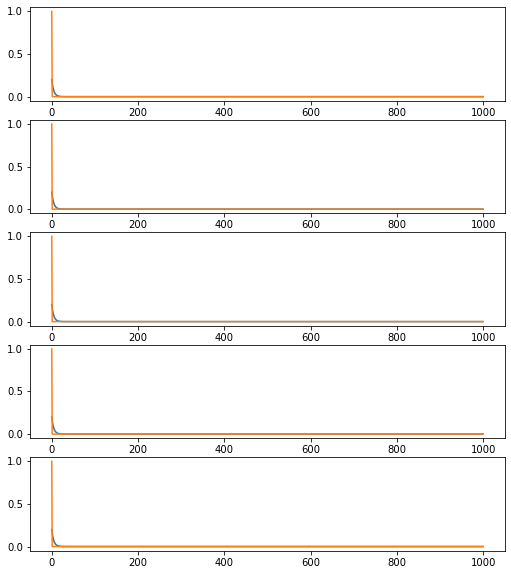

In [8]:
import math
from RR_RAPPOR import RAPPOR
import numpy as np
from IDLDP.pg1 import IDLDP

import matplotlib.pyplot as plt

k = 1000 #absz
n = 10000
elements = range(0,k) #ab
lbd = 0.8 #parameter for geometric dist
eps = 1 # privacy_para
prob = [(1-lbd)*math.pow(lbd,x)/(1-math.pow(lbd,k)) for x in elements] # geometric dist
#prob = [1/float(k)] * k
in_list = np.random.choice(elements, n, p=prob) #input symbols


# idldp params
privacy_budget = [1, 1.2, 2]
tier_split_percentages = [.05, .05, .9]
domain_size = k
total_records = n
opt_mode = 1
idldp = IDLDP()



fig, ax = plt.subplots(nrows=5, ncols=1) 
fig.set_size_inches(8.5, 10)


for opt_mode in range(5):
  print(f"checking opt mode {opt_mode}\n\n")
  X, pred_MSE, config = idldp.gen_perturbation_probs(
    eps,
    privacy_budget,
    tier_split_percentages=tier_split_percentages,
    domain_size=k,
    total_records = n,
    opt_mode = opt_mode,
  )


  rappor = RAPPOR(k,eps, config=config)
  out_list = rappor.id_ldp_perturb(in_list, **config)
  outp,temp = np.histogram(out_list,range(k+1))
  prob_est = rappor.decode_counts(outp,n) # estimate the original underlying distribution
  print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
  print ("prob_sum: ", str(sum(prob_est)))
  prob_est = rappor.decode_counts(outp,n,1) # estimate the original underlying distribution
  ax[opt_mode].plot(elements,prob)
  ax[opt_mode].plot(elements,prob_est)
  #plt.plot(prob_est)
  print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
  print ("prob_sum: ", str(sum(prob_est)))
  # plt.pause(0.1)
# plt.close()